# Automotive Dataset Analysis

In [150]:
#Import all Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.formula.api import ols 
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.neighbors import KNeighborsClassifier as knnc 
from sklearn.naive_bayes import GaussianNB as gnb 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix 
import scipy.stats as stats 

# Data Exploration & Cleaning

In [151]:
#Read dataset file

df = pd.read_csv('data_science_automotive.csv')

In [152]:
#Explore null values and data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170 entries, 0 to 5169
Data columns (total 54 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   Manufacturer                                         5170 non-null   object
 1   Model Year                                           5170 non-null   object
 2   Regulatory Class                                     5170 non-null   object
 3   Vehicle Type                                         5170 non-null   object
 4   Production (000)                                     5170 non-null   object
 5   Production Share                                     5170 non-null   object
 6   2-Cycle MPG                                          5170 non-null   object
 7   Real-World MPG                                       5170 non-null   object
 8   Real-World MPG_City                                  5170 non-null   object
 9

In [153]:
#Explore dataset

df.describe()

,Manufacturer,Model Year,Regulatory Class,Vehicle Type,Production (000),Production Share,2-Cycle MPG,Real-World MPG,Real-World MPG_City,Real-World MPG_Hwy,...,Multivalve Engine,Variable Valve Timing,Average Number of Gears,Transmission - CVT (Non-Hybrid),4 or Fewer Gears,5 Gears,6 Gears,7 Gears,8 Gears,9 or More Gears
count,5170,5170,5170,5170,5170,5170,5170,5170,5170,5170,...,5170,5170,5170,5170,5170,5170,5170,5170,5170,5170
unique,15,47,3,8,1520,390,3382,3389,3383,3391,...,592,480,87,347,831,753,580,185,316,206
top,All,1975,Truck,All,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
freq,376,110,2397,705,1300,1300,1198,1198,1198,1198,...,2439,3306,1421,4440,2225,2305,3471,4674,4668,4899


In [154]:
#Rename column

df = df.rename(columns = {"Production (000)":"Production in Thousands"})

In [155]:
#Drop columns/observations that are not meaningful for regression analysis:



#Drop discontinued car model observations that have 0 production 

data_mod = df.drop(df.index[df['Production in Thousands'] == 0])


#Drop new car models/innovation observations that have 0 production projections

data_mod.drop(df.index[df['Production in Thousands'] == '-'], inplace = True)


#Drop duplicated column: 'Production Share' is not needed when we have 'Production Quantity'

del data_mod['Production Share']


#Drop unecessary columns

del data_mod['2-Cycle MPG']

del data_mod['Powertrain - Other (incl. CNG)']


#Drop duplicated columns: individual gear types are not needed when we have 'Average Number of Gears'

del data_mod['4 or Fewer Gears']
del data_mod['5 Gears']
del data_mod['6 Gears']
del data_mod['7 Gears']
del data_mod['8 Gears']
del data_mod['9 or More Gears']


In [156]:
#Drop aggregate entries to avoid double-counting

data_mod.drop(data_mod.index[data_mod['Manufacturer'] == 'All'], inplace = True)

data_mod.drop(data_mod.index[data_mod['Regulatory Class'] == 'All'], inplace = True)

data_mod.drop(data_mod.index[data_mod['Vehicle Type'] == 'All'], inplace = True)

data_mod.drop(data_mod.index[data_mod['Vehicle Type'] == 'All Car'], inplace = True)

data_mod.drop(data_mod.index[data_mod['Vehicle Type'] == 'All Truck'],inplace = True)


In [157]:
#Change data types

data_mod['Model Year'] = data_mod['Model Year'].astype(int)

data_mod['Production in Thousands'] = data_mod['Production in Thousands'].astype(int)

data_mod.iloc[:,5:] = data_mod.iloc[:,5:].replace("-",0)

data_mod.iloc[:, 5:] = data_mod.iloc[:, 5:].apply(lambda x: x.str.replace(',', '').astype(float), axis=1)



In [158]:
#View revised data types
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1875 entries, 304 to 5049
Data columns (total 45 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Manufacturer                                         1875 non-null   object 
 1   Model Year                                           1875 non-null   int32  
 2   Regulatory Class                                     1875 non-null   object 
 3   Vehicle Type                                         1875 non-null   object 
 4   Production in Thousands                              1875 non-null   int32  
 5   Real-World MPG                                       1875 non-null   float64
 6   Real-World MPG_City                                  1875 non-null   float64
 7   Real-World MPG_Hwy                                   1875 non-null   float64
 8   Real-World CO2 (g/mi)                                1875 non-null

In [159]:
#View null values in columns

data_mod.isna().sum()

Manufacturer                                              0
Model Year                                                0
Regulatory Class                                          0
Vehicle Type                                              0
Production in Thousands                                   0
Real-World MPG                                            0
Real-World MPG_City                                       0
Real-World MPG_Hwy                                        0
Real-World CO2 (g/mi)                                     0
Real-World CO2_City (g/mi)                                0
Real-World CO2_Hwy (g/mi)                                 0
Weight (lbs)                                              0
Footprint (sq. ft.)                                    1205
Engine Displacement                                      17
Horsepower (HP)                                           0
Acceleration (0-60 time in seconds)                      84
HP/Engine Displacement                  

# Data Transformations & Further Cleaning

In [160]:
#Data Transformations: impute null values in columns

data_mod['Real-World MPG'] = data_mod['Real-World MPG'].fillna(data_mod['Real-World MPG'].mean())

data_mod['Footprint (sq. ft.)'] = data_mod['Footprint (sq. ft.)'].fillna(data_mod.groupby(['Vehicle Type','Manufacturer'])['Footprint (sq. ft.)'].transform('median'))

data_mod['Engine Displacement'] = data_mod['Engine Displacement'].fillna(data_mod.groupby('Manufacturer')['Engine Displacement'].transform('median'))

data_mod['Acceleration (0-60 time in seconds)'] = data_mod['Acceleration (0-60 time in seconds)'].fillna(data_mod.groupby(['Vehicle Type','Manufacturer'])['Acceleration (0-60 time in seconds)'].transform('median'))

data_mod['HP/Engine Displacement'] = data_mod['HP/Engine Displacement'].fillna(data_mod.groupby('Vehicle Type')['HP/Engine Displacement'].transform('median'))

data_mod['Drivetrain - Front'] = data_mod['Drivetrain - Front'].fillna(data_mod.groupby(['Vehicle Type','Manufacturer'])['Drivetrain - Front'].transform('median'))

data_mod['Drivetrain - Front'] = data_mod['Drivetrain - Front'].fillna(data_mod.groupby('Manufacturer')['Drivetrain - Front'].transform('median'))

data_mod['Drivetrain - Front'] = data_mod['Drivetrain - Front'].fillna(data_mod.groupby('Vehicle Type')['Drivetrain - Front'].transform('median'))

data_mod['Drivetrain - 4WD'] = data_mod['Drivetrain - 4WD'].fillna(data_mod.groupby('Manufacturer')['Drivetrain - 4WD'].transform('median'))

data_mod['Drivetrain - Rear'] = data_mod['Drivetrain - Rear'].fillna(data_mod.groupby(['Vehicle Type','Manufacturer'])['Drivetrain - Rear'].transform('median'))

data_mod['Drivetrain - Rear'] = data_mod['Drivetrain - Rear'].fillna(data_mod.groupby('Manufacturer')['Drivetrain - Rear'].transform('median'))

data_mod['Transmission - Manual'] = data_mod['Transmission - Manual'].fillna(data_mod.groupby(['Vehicle Type','Manufacturer'])['Transmission - Manual'].transform('median'))

data_mod['Transmission - Manual'] = data_mod['Transmission - Manual'].fillna(data_mod.groupby('Manufacturer')['Transmission - Manual'].transform('median'))

data_mod['Transmission - Manual'] = data_mod['Transmission - Manual'].fillna(data_mod.groupby('Vehicle Type')['Transmission - Manual'].transform('median'))

data_mod['Transmission - Automatic'] = data_mod['Transmission - Automatic'].fillna(data_mod.groupby(['Vehicle Type','Manufacturer'])['Transmission - Automatic'].transform('median'))

data_mod['Transmission - Automatic'] = data_mod['Transmission - Automatic'].fillna(data_mod.groupby('Manufacturer')['Transmission - Automatic'].transform('median'))

data_mod['Transmission - Lockup'] = data_mod['Transmission - Lockup'].fillna(data_mod.groupby(['Vehicle Type','Manufacturer'])['Transmission - Lockup'].transform('median'))

data_mod['Transmission - Lockup'] = data_mod['Transmission - Lockup'].fillna(data_mod.groupby('Vehicle Type')['Transmission - Lockup'].transform('median'))

data_mod['Transmission - CVT (Hybrid)'] = data_mod['Transmission - CVT (Hybrid)'].fillna(data_mod.groupby(['Vehicle Type','Manufacturer'])['Transmission - CVT (Hybrid)'].transform('median'))

data_mod['Transmission - CVT (Hybrid)'] = data_mod['Transmission - CVT (Hybrid)'].fillna(data_mod.groupby('Manufacturer')['Transmission - CVT (Hybrid)'].transform('median'))

data_mod['Transmission - CVT (Hybrid)'] = data_mod['Transmission - CVT (Hybrid)'].fillna(data_mod.groupby('Vehicle Type')['Transmission - CVT (Hybrid)'].transform('median'))

data_mod['Transmission - Other'] = data_mod['Transmission - Other'].fillna(data_mod.groupby(['Vehicle Type','Manufacturer'])['Transmission - Other'].transform('median'))

data_mod['Transmission - Other'] = data_mod['Transmission - Other'].fillna(data_mod.groupby('Manufacturer')['Transmission - Other'].transform('median'))

data_mod['Transmission - Other'] = data_mod['Transmission - Other'].fillna(data_mod.groupby('Vehicle Type')['Transmission - Other'].transform('median'))

data_mod['Fuel Delivery - Carbureted'] = data_mod['Fuel Delivery - Carbureted'].fillna(data_mod.groupby(['Vehicle Type','Manufacturer'])['Fuel Delivery - Carbureted'].transform('median'))

data_mod['Fuel Delivery - Carbureted'] = data_mod['Fuel Delivery - Carbureted'].fillna(data_mod.groupby('Manufacturer')['Fuel Delivery - Carbureted'].transform('median'))

data_mod['Fuel Delivery - Carbureted'] = data_mod['Fuel Delivery - Carbureted'].fillna(data_mod.groupby('Vehicle Type')['Fuel Delivery - Carbureted'].transform('median'))

data_mod['Fuel Delivery - Gasoline Direct Injection (GDI)'] = data_mod['Fuel Delivery - Gasoline Direct Injection (GDI)'].fillna(data_mod.groupby(['Vehicle Type','Manufacturer'])['Fuel Delivery - Gasoline Direct Injection (GDI)'].transform('median'))

data_mod['Fuel Delivery - Gasoline Direct Injection (GDI)'] = data_mod['Fuel Delivery - Gasoline Direct Injection (GDI)'].fillna(data_mod.groupby('Manufacturer')['Fuel Delivery - Gasoline Direct Injection (GDI)'].transform('median'))

data_mod['Fuel Delivery - Gasoline Direct Injection (GDI)'] = data_mod['Fuel Delivery - Gasoline Direct Injection (GDI)'].fillna(data_mod.groupby('Vehicle Type')['Fuel Delivery - Gasoline Direct Injection (GDI)'].transform('median'))

data_mod['Fuel Delivery - Port Fuel Injection'] = data_mod['Fuel Delivery - Port Fuel Injection'].fillna(data_mod.groupby(['Vehicle Type','Manufacturer'])['Fuel Delivery - Port Fuel Injection'].transform('median'))

data_mod['Fuel Delivery - Port Fuel Injection'] = data_mod['Fuel Delivery - Port Fuel Injection'].fillna(data_mod.groupby('Manufacturer')['Fuel Delivery - Port Fuel Injection'].transform('median'))

data_mod['Fuel Delivery - Port Fuel Injection'] = data_mod['Fuel Delivery - Port Fuel Injection'].fillna(data_mod.groupby('Vehicle Type')['Fuel Delivery - Port Fuel Injection'].transform('median'))

data_mod['Powertrain - Electric Vehicle (EV)'] = data_mod['Powertrain - Electric Vehicle (EV)'].fillna(data_mod.groupby(['Vehicle Type','Manufacturer'])['Powertrain - Electric Vehicle (EV)'].transform('median'))

data_mod['Powertrain - Electric Vehicle (EV)'] = data_mod['Powertrain - Electric Vehicle (EV)'].fillna(data_mod.groupby('Manufacturer')['Powertrain - Electric Vehicle (EV)'].transform('median'))

data_mod['Powertrain - Electric Vehicle (EV)'] = data_mod['Powertrain - Electric Vehicle (EV)'].fillna(data_mod.groupby('Vehicle Type')['Powertrain - Electric Vehicle (EV)'].transform('median'))

data_mod['Transmission - CVT (Non-Hybrid)'] = data_mod['Transmission - CVT (Non-Hybrid)'].fillna(data_mod.groupby('Manufacturer')['Transmission - CVT (Non-Hybrid)'].transform('median'))

data_mod['Transmission - CVT (Non-Hybrid)'] = data_mod['Transmission - CVT (Non-Hybrid)'].fillna(data_mod.groupby('Vehicle Type')['Transmission - CVT (Non-Hybrid)'].transform('median'))

data_mod['Average Number of Gears'] = data_mod['Average Number of Gears'].fillna(data_mod.groupby('Manufacturer')['Average Number of Gears'].transform('median'))

data_mod['Variable Valve Timing'] = data_mod['Variable Valve Timing'].fillna(data_mod.groupby('Manufacturer')['Variable Valve Timing'].transform('median'))

data_mod['Multivalve Engine'] = data_mod['Multivalve Engine'].fillna(data_mod.groupby('Manufacturer')['Multivalve Engine'].transform('median'))

data_mod['Cylinder Deactivation'] = data_mod['Cylinder Deactivation'].fillna(data_mod.groupby('Vehicle Type')['Cylinder Deactivation'].transform('median'))

data_mod['Multivalve Engine'] = data_mod['Multivalve Engine'].fillna(data_mod.groupby('Vehicle Type')['Multivalve Engine'].transform('median'))

data_mod['Variable Valve Timing '] = data_mod['Variable Valve Timing'].fillna(data_mod.groupby('Vehicle Type')['Variable Valve Timing'].transform('median'))

data_mod['Stop/Start'] = data_mod['Stop/Start'].fillna(data_mod.groupby('Vehicle Type')['Stop/Start'].transform('median'))

data_mod['Turbocharged Engine'] = data_mod['Turbocharged Engine'].fillna(data_mod.groupby('Vehicle Type')['Turbocharged Engine'].transform('median'))

data_mod['Powertrain - Gasoline'] = data_mod['Powertrain - Gasoline'].fillna(data_mod.groupby('Vehicle Type')['Powertrain - Gasoline'].transform('median'))

data_mod['Powertrain - Gasoline Hybrid'] = data_mod['Powertrain - Gasoline Hybrid'].fillna(data_mod.groupby('Vehicle Type')['Powertrain - Gasoline Hybrid'].transform('median'))

data_mod['Powertrain - Gasoline Hybrid'] = data_mod['Powertrain - Gasoline Hybrid'].fillna(data_mod.groupby('Manufacturer')['Powertrain - Gasoline Hybrid'].transform('median'))

data_mod['Powertrain - Fuel Cell Vehicle (FCV)'] = data_mod['Powertrain - Fuel Cell Vehicle (FCV)'].fillna(data_mod.groupby('Vehicle Type')['Powertrain - Fuel Cell Vehicle (FCV)'].transform('median'))

data_mod['Powertrain - Fuel Cell Vehicle (FCV)'] = data_mod['Powertrain - Fuel Cell Vehicle (FCV)'].fillna(data_mod.groupby('Manufacturer')['Powertrain - Fuel Cell Vehicle (FCV)'].transform('median'))

data_mod['Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)'] = data_mod['Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)'].fillna(data_mod.groupby('Vehicle Type')['Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)'].transform('median'))

data_mod['Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)'] = data_mod['Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)'].fillna(data_mod.groupby('Manufacturer')['Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)'].transform('median'))

data_mod['Powertrain - Electric Vehicle (EV) '] = data_mod['Powertrain - Electric Vehicle (EV)'].fillna(data_mod.groupby(['Manufacturer','Vehicle Type'])['Powertrain - Electric Vehicle (EV)'].transform('median'))

data_mod['Powertrain - Diesel'] = data_mod['Powertrain - Diesel'].fillna(data_mod.groupby('Vehicle Type')['Powertrain - Diesel'].transform('median'))

data_mod['Fuel Delivery - Other'] = data_mod['Fuel Delivery - Other'].fillna(data_mod.groupby('Vehicle Type')['Fuel Delivery - Other'].transform('median'))

data_mod['Fuel Delivery - Throttle Body Injection'] = data_mod['Fuel Delivery - Throttle Body Injection'].fillna(data_mod.groupby('Vehicle Type')['Fuel Delivery - Throttle Body Injection'].transform('median'))

data_mod['Variable Valve Timing'] = data_mod['Variable Valve Timing'].fillna(data_mod.groupby('Vehicle Type')['Variable Valve Timing'].transform('median'))

data_mod['Footprint (sq. ft.)'] = data_mod['Footprint (sq. ft.)'].fillna(data_mod.groupby('Vehicle Type')['Footprint (sq. ft.)'].transform('median'))

data_mod['Engine Displacement'] = data_mod['Engine Displacement'].fillna(data_mod.groupby('Vehicle Type')['Engine Displacement'].transform('median'))


In [161]:
#No more null values within columns
data_mod.isna().sum()

Manufacturer                                           0
Model Year                                             0
Regulatory Class                                       0
Vehicle Type                                           0
Production in Thousands                                0
Real-World MPG                                         0
Real-World MPG_City                                    0
Real-World MPG_Hwy                                     0
Real-World CO2 (g/mi)                                  0
Real-World CO2_City (g/mi)                             0
Real-World CO2_Hwy (g/mi)                              0
Weight (lbs)                                           0
Footprint (sq. ft.)                                    0
Engine Displacement                                    0
Horsepower (HP)                                        0
Acceleration (0-60 time in seconds)                    0
HP/Engine Displacement                                 0
HP/Weight (lbs)                

In [162]:
#View column headers to determine if renaming is required

data_mod.columns

Index(['Manufacturer', 'Model Year', 'Regulatory Class', 'Vehicle Type',
       'Production in Thousands', 'Real-World MPG', 'Real-World MPG_City',
       'Real-World MPG_Hwy', 'Real-World CO2 (g/mi)',
       'Real-World CO2_City (g/mi)', 'Real-World CO2_Hwy (g/mi)',
       'Weight (lbs)', 'Footprint (sq. ft.)', 'Engine Displacement',
       'Horsepower (HP)', 'Acceleration (0-60 time in seconds)',
       'HP/Engine Displacement', 'HP/Weight (lbs)', 'Ton-MPG (Real-World)',
       'Drivetrain - Front', 'Drivetrain - 4WD', 'Drivetrain - Rear',
       'Transmission - Manual', 'Transmission - Automatic',
       'Transmission - Lockup', 'Transmission - CVT (Hybrid)',
       'Transmission - Other', 'Fuel Delivery - Carbureted',
       'Fuel Delivery - Gasoline Direct Injection (GDI)',
       'Fuel Delivery - Port Fuel Injection',
       'Fuel Delivery - Throttle Body Injection', 'Fuel Delivery - Other',
       'Powertrain - Diesel', 'Powertrain - Electric Vehicle (EV)',
       'Powertrain - 

In [163]:
#Rename column headers to remove parantheses

data_mod = data_mod.rename(columns = {"RealWorld CO2 (g/mi)":"RealWorld_CO2"})
data_mod = data_mod.rename(columns = {"RealWorld CO2_City (g/mi)":"RealWorld_CO2_City"})
data_mod = data_mod.rename(columns = {"RealWorld CO2_Hwy (g/mi)":"RealWorld_CO2_City"})
data_mod = data_mod.rename(columns = {"RealWorld CO2_Hwy (g/mi)":"RealWorld_CO2_Hwy"})
data_mod = data_mod.rename(columns = {"Weight (lbs)":"Vehicle_Weight"})
data_mod = data_mod.rename(columns = {"Footprint (sq. ft.)":"Vehicle_Footprint"})
data_mod = data_mod.rename(columns = {"Horsepower (HP)":"Horsepower"})
data_mod = data_mod.rename(columns = {"Acceleration (060 time in seconds)":"Acceleration"})
data_mod = data_mod.rename(columns = {"HP/Weight (lbs)":"HP/Weight"})
data_mod = data_mod.rename(columns = {"TonMPG (RealWorld)":"TonMPG_RealWorld"})
data_mod = data_mod.rename(columns = {"Transmission  CVT (Hybrid)":"Transmission_CVT_Hybrid"})
data_mod = data_mod.rename(columns = {"Fuel Delivery  Gasoline Direct Injection (GDI)":"Fuel_Delivery_Gasoline_Direct_Injection"})
data_mod = data_mod.rename(columns = {"Powertrain  Electric Vehicle (EV)":"Powertrain_Electric_Vehicle"})
data_mod = data_mod.rename(columns = {"Powertrain  Plugin Hybrid Electric Vehicle (PHEV)":"Powertrain_Plugin_Hybrid_Electric_Vehicle"})
data_mod = data_mod.rename(columns = {"Powertrain  Fuel Cell Vehicle (FCV)":"Powertrain_Fuel_Cell_Vehicle"})
data_mod = data_mod.rename(columns = {"Powertrain  Other (incl. CNG)":"Powertrain_Other"})
data_mod = data_mod.rename(columns = {"Transmission  CVT (NonHybrid)":"Transmission_CVT_NonHybrid"})

# Correlation Testing & Data Distribution

<AxesSubplot:>

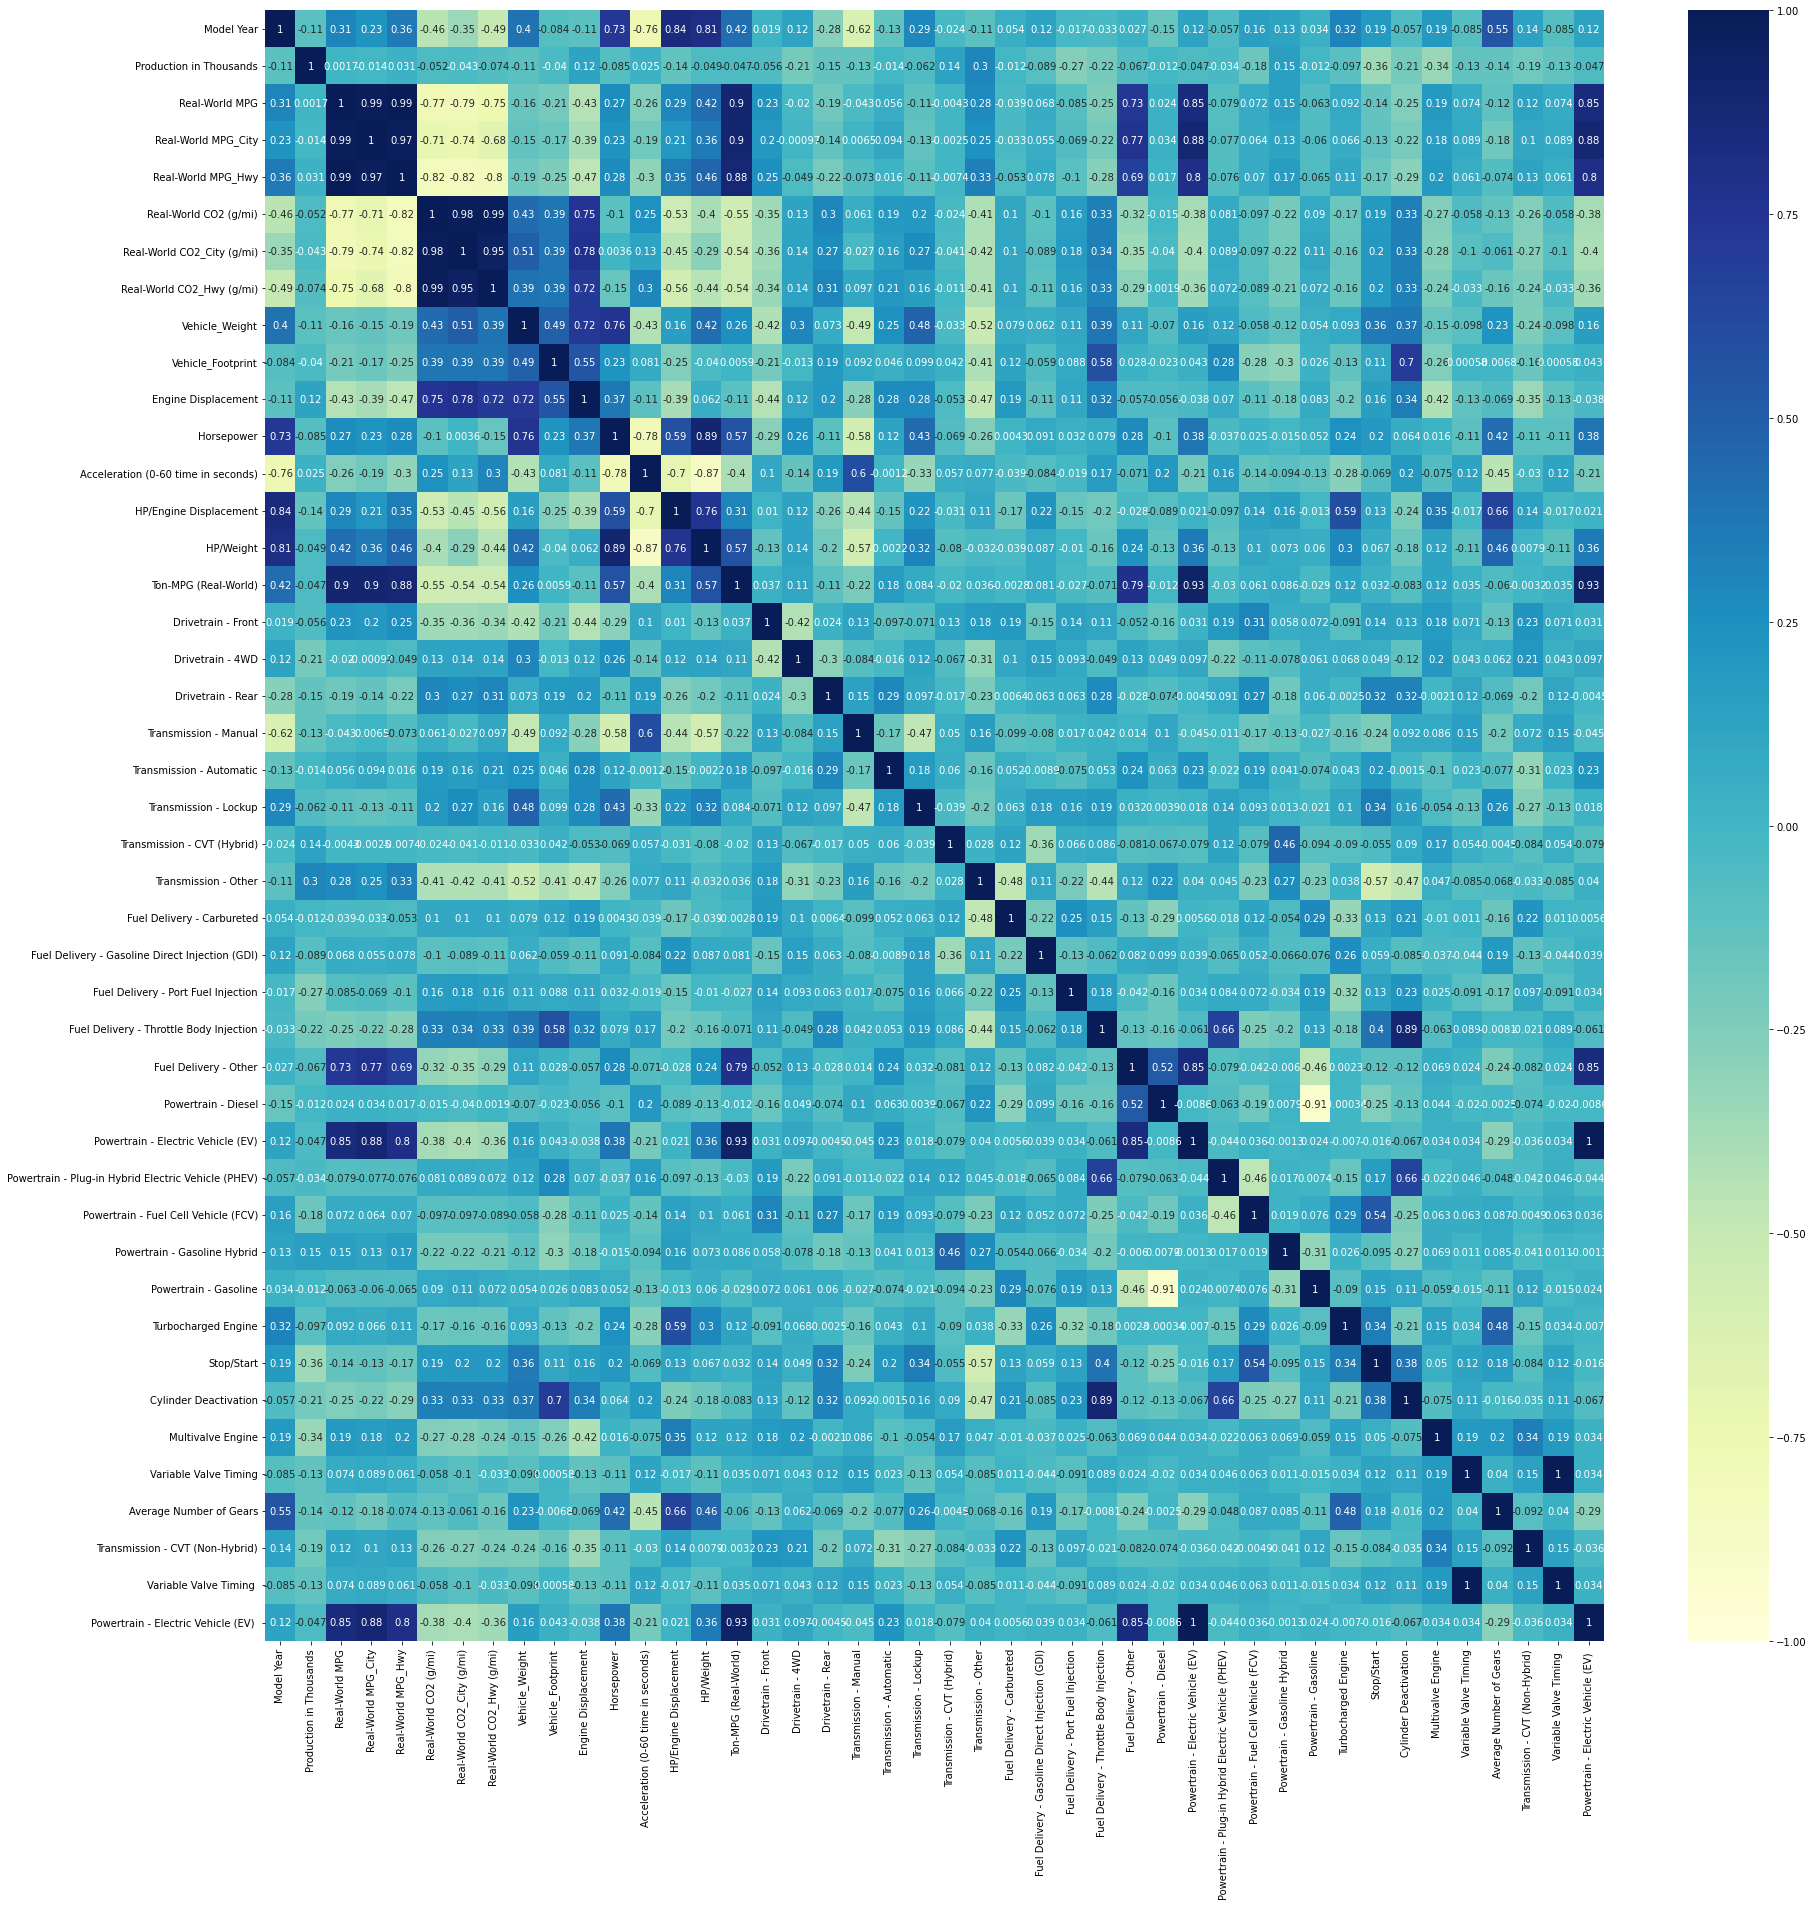

In [164]:
#Visual analysis: heatmap - no clear correlations due to high number of variables

plt.figure(figsize=(30,30))

sns.heatmap(data_mod[data_mod["Production in Thousands"]>0.5].corr(),vmin=-1,vmax=1, annot=True, cmap="YlGnBu")

In [165]:
#Visualize correlations to "Production in Thousands" target variable in array format for clear distinctions.
#Results show extremely low correlation between all variables, meaning that normalization and additional transformations of data are required.

correlation = data_mod.corr()
correlations = correlation.iloc[1]
correlations.sort_values()

Stop/Start                                            -0.358318
Multivalve Engine                                     -0.343898
Fuel Delivery - Port Fuel Injection                   -0.267319
Fuel Delivery - Throttle Body Injection               -0.215587
Drivetrain - 4WD                                      -0.211879
Cylinder Deactivation                                 -0.208810
Transmission - CVT (Non-Hybrid)                       -0.193849
Powertrain - Fuel Cell Vehicle (FCV)                  -0.180159
Drivetrain - Rear                                     -0.148025
HP/Engine Displacement                                -0.135859
Transmission - Manual                                 -0.135454
Average Number of Gears                               -0.133950
Variable Valve Timing                                 -0.128838
Variable Valve Timing                                 -0.128838
Model Year                                            -0.105623
Vehicle_Weight                          

c:\Users\chris\anaconda3\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


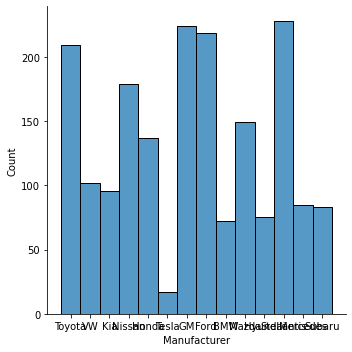

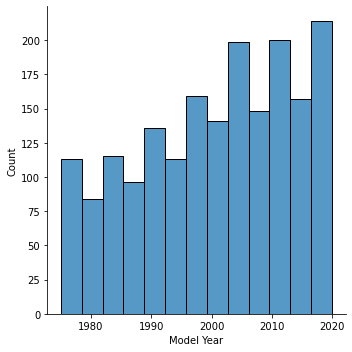

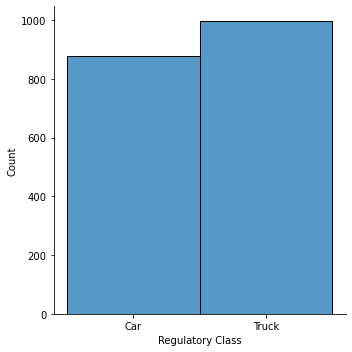

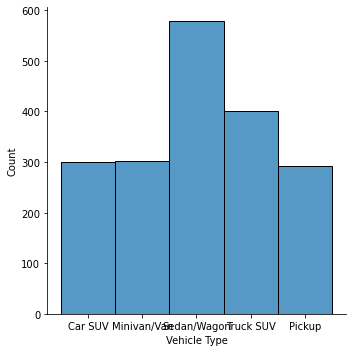

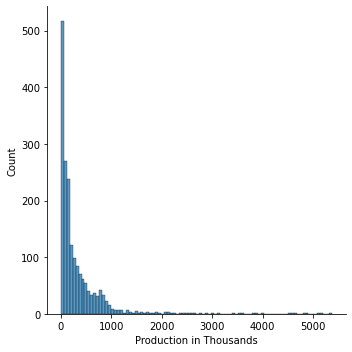

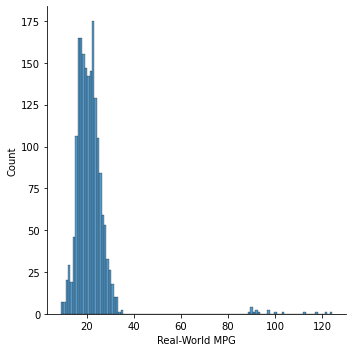

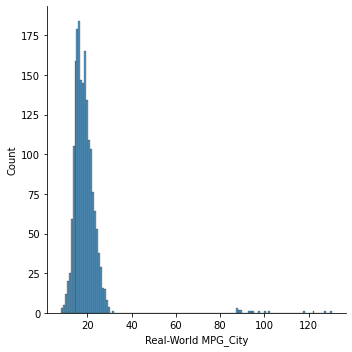

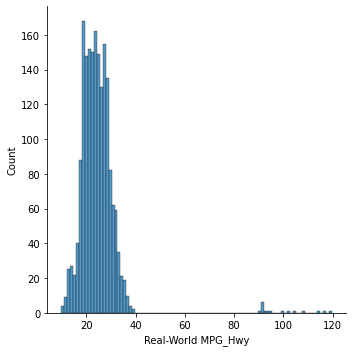

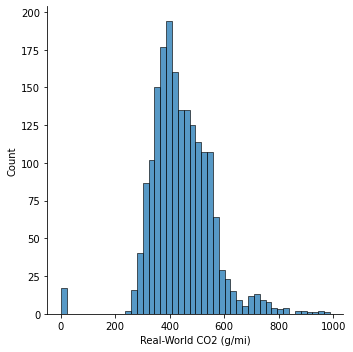

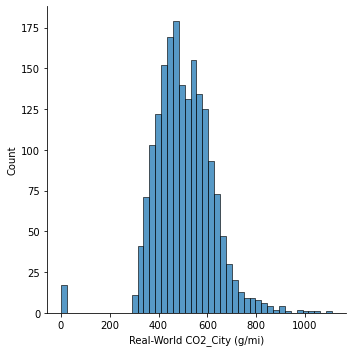

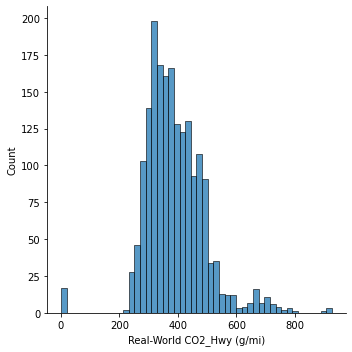

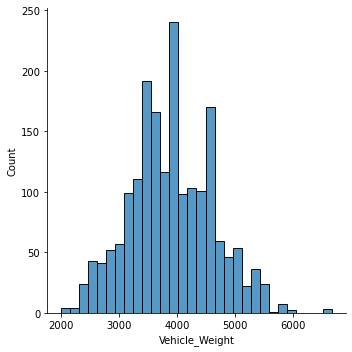

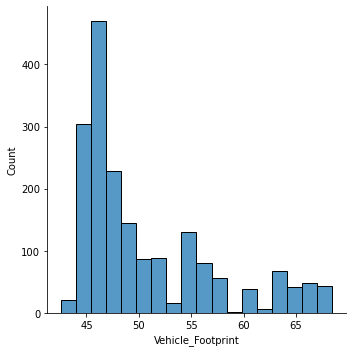

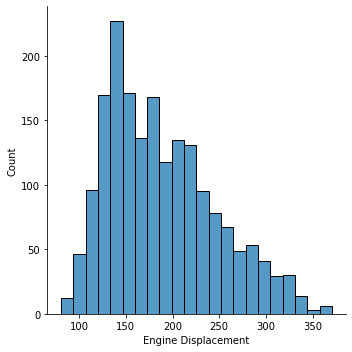

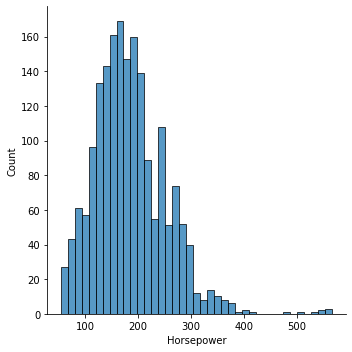

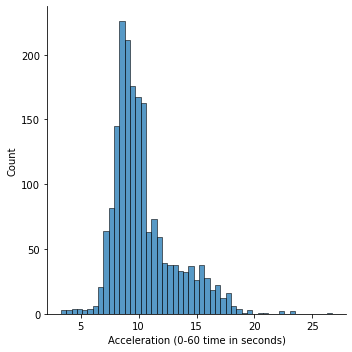

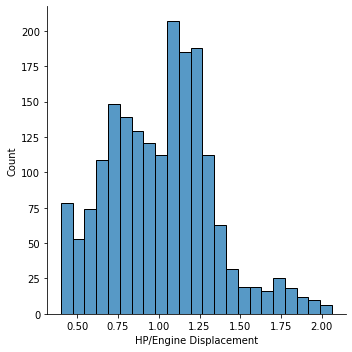

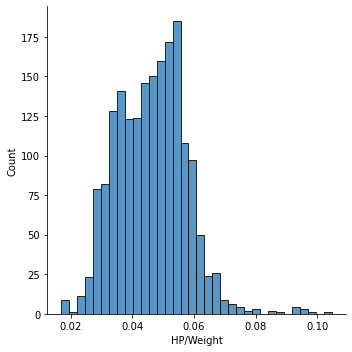

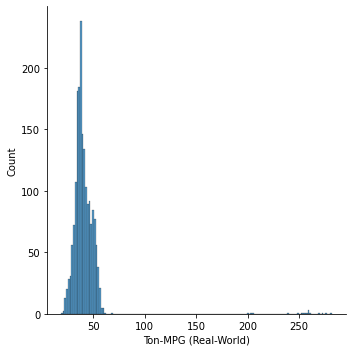

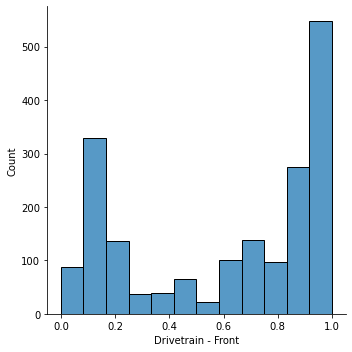

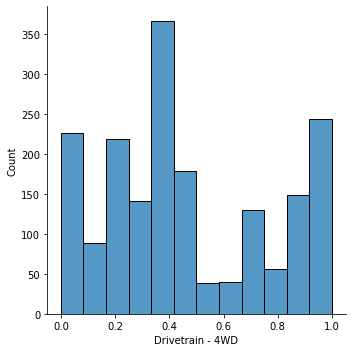

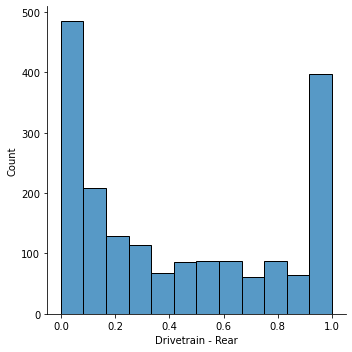

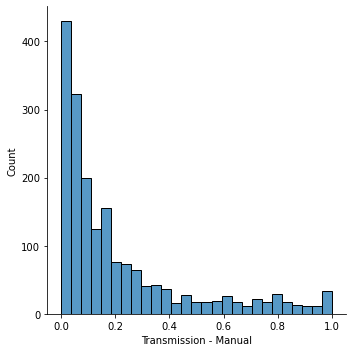

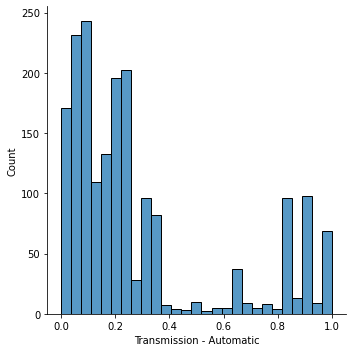

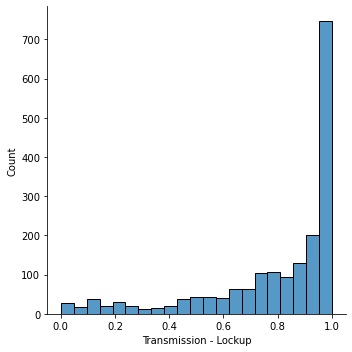

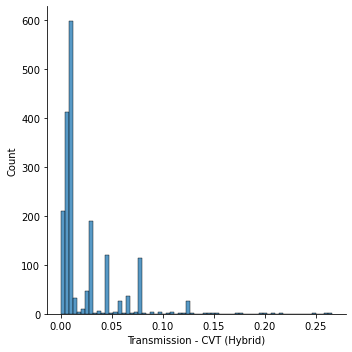

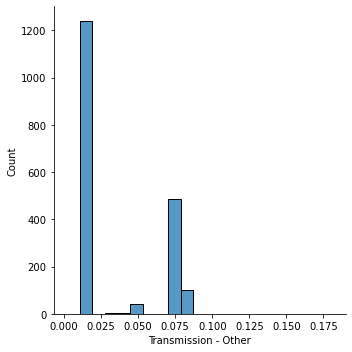

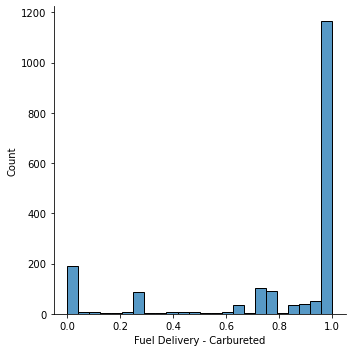

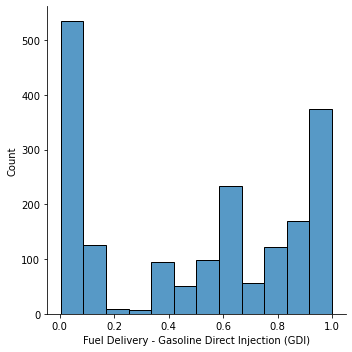

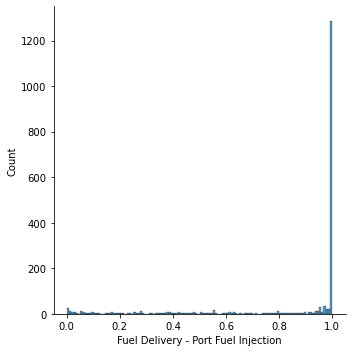

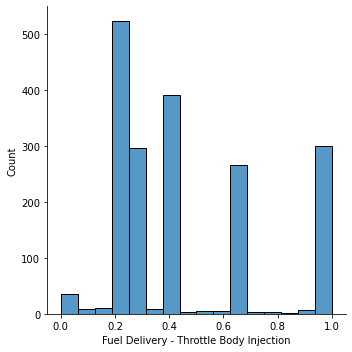

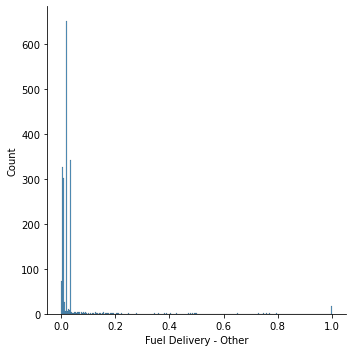

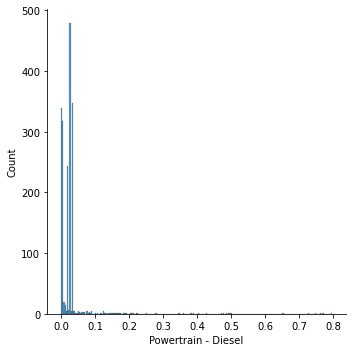

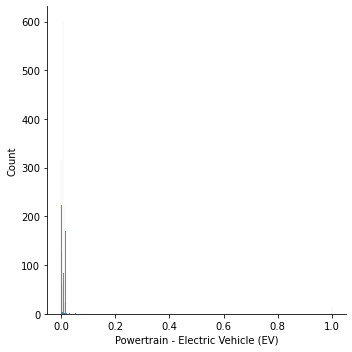

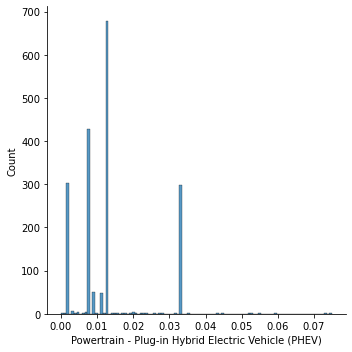

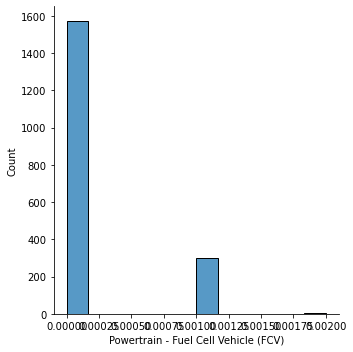

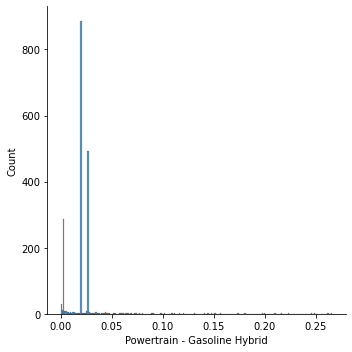

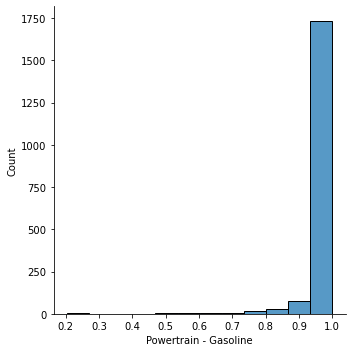

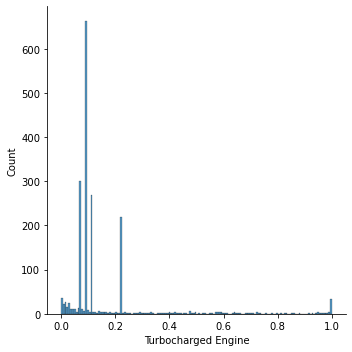

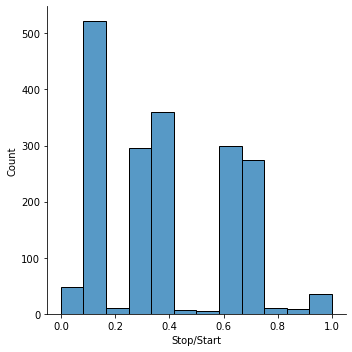

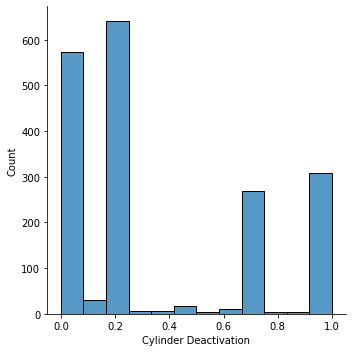

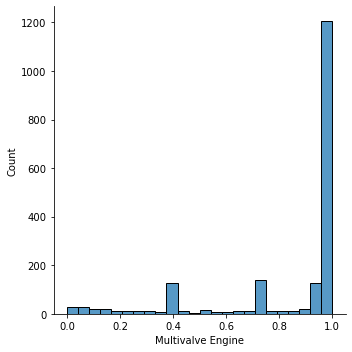

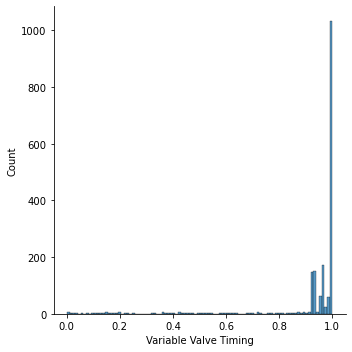

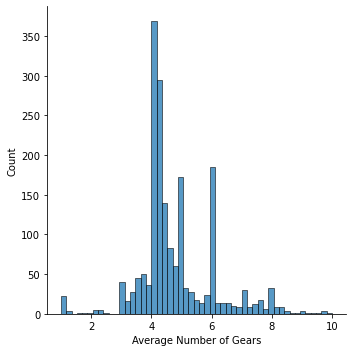

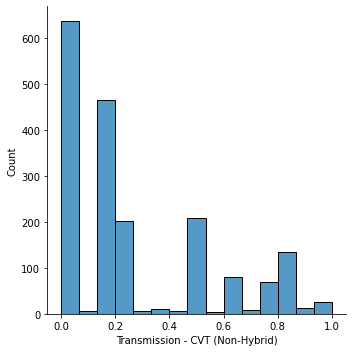

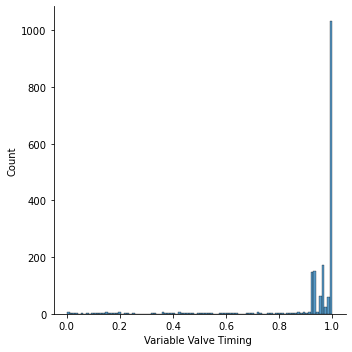

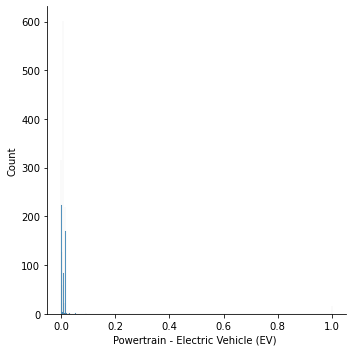

In [166]:
#Visually analyze distribution of data - which doesn't appear to be normally distributed for most variables, and skewing to the left is noticeable.
#Select x and y variables to run for an initial regression test based on current data distribution.

for i in data_mod.iloc[1:10]:
    sns.displot(data = data_mod, x=i)

In [167]:
#Rename columns to remove spaces for the selected x and y variables, prior to running the regression.
data_mod = data_mod.rename(columns = {"Turbocharged Engine":"Turbocharged_Engine"})
data_mod = data_mod.rename(columns = {"Real-World MPG":"Real_World_MPG"})
data_mod = data_mod.rename(columns = {"Real-World MPG_Hwy":"Real_World_MPG_Hwy"})

# Preliminary Regression Test

In [168]:
#Define x and y variables
x = data_mod[['Real_World_MPG_Hwy','Turbocharged_Engine']]
y = data_mod['Real_World_MPG']

In [169]:
#Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)

In [170]:
#Train the model
train_model = LinearRegression().fit(x_train, y_train)

In [171]:
#Print the coefficients and y-intercept
print(train_model.coef_)
print(train_model.intercept_)

[ 0.977613   -0.65710972]
-2.282810700547479


In [172]:
#Build a prediction
predict = train_model.predict(x_test)

In [173]:
#Analyze test regression output - R2 appears to be a good score, however this is misleading because variables are skewed to the left (in the same direction as the target variable).
test_rmse = (np.sqrt(mean_squared_error(y_test, predict)))
test_r2 = r2_score(y_test, predict)
print(test_rmse) #the lower the value, the better the fit
print(test_r2) #the closer to 1, the better the fit

1.0846409063347893
0.9878716940733864


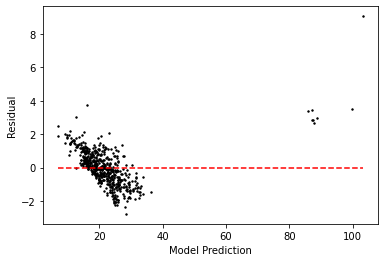

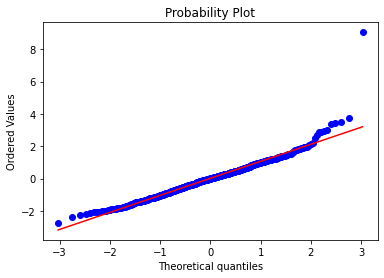

In [174]:
#Understand residual spread - confirms that further testing and transformations need to be conducted.
residuals = y_test - predict

plt.scatter(predict,residuals,s=2,c='black') 

plt.hlines(0,min(predict),max(predict),color='red',linestyles='dashed') 

plt.xlabel("Model Prediction")
plt.ylabel("Residual")
plt.show()

#Create QQ Plot
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(residuals,dist='norm',plot=ax)
plt.show()
data_mod = data_mod.rename(columns = {"Production in Thousands":"Production_in_Thousands"})
data_mod = data_mod.rename(columns = {"Production in Thousands":"Production_in_Thousands"})
a = data_mod[['Real_World_MPG_Hwy','Turbocharged_Engine','Real_World_MPG']]
b = data_mod['Production_in_Thousands']
a_train, a_test, b_train, b_test = train_test_split(a,b, test_size=0.3)

# Re-run Preliminary Regression Test but with the Selection of Different X and Y Variables for Further Testing

In [175]:
#Rename column to remove spaces, and set this as the new target variable.
data_mod = data_mod.rename(columns = {"Production in Thousands":"Production_in_Thousands"})

In [176]:
#Try to run the regression again, but with different variables selected for the model to determine if an improved R2 and RMSE score can be achieved.
a = data_mod[['Real_World_MPG_Hwy','Turbocharged_Engine','Real_World_MPG']]
b = data_mod['Production_in_Thousands']

In [177]:
#Split the new data into training and testing.
a_train, a_test, b_train, b_test = train_test_split(a,b, test_size=0.3)

In [178]:
#Train the model.
train_model2 = LinearRegression().fit(a_train, b_train)

In [179]:
#Build a prediction.
predict2 = train_model2.predict(a_test)

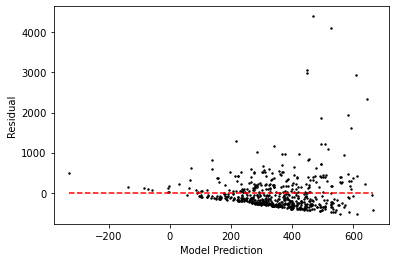

In [180]:
#Visualize the results with a scatter plot.
residuals2 = b_test - predict2

plt.scatter(predict2,residuals2,s=2,c='black') #s is the size of dots

plt.hlines(0,min(predict2),max(predict2),color='red',linestyles='dashed') #plot a horizontal red line

plt.xlabel("Model Prediction")
plt.ylabel("Residual")
plt.show()

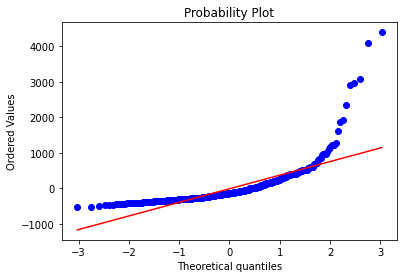

In [181]:
#Visualize the results with a probability plot.
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(residuals2,dist='norm',plot=ax)
plt.show()

In [182]:
for i in data_mod['Production_in_Thousands']:
    if i == 0:
        print(data_mod.iloc[i])

Manufacturer                                              Toyota
Model Year                                                  1975
Regulatory Class                                             Car
Vehicle Type                                             Car SUV
Production_in_Thousands                                        6
Real_World_MPG                                          10.23844
Real-World MPG_City                                        9.045
Real_World_MPG_Hwy                                        12.207
Real-World CO2 (g/mi)                                  868.00369
Real-World CO2_City (g/mi)                             982.53179
Real-World CO2_Hwy (g/mi)                               728.0249
Vehicle_Weight                                            4000.0
Vehicle_Footprint                                       46.08006
Engine Displacement                                        257.0
Horsepower                                                 110.0
Acceleration (0-60 time i

In [183]:
data_mod.loc[data_mod['Production_in_Thousands'] < 5]

,Manufacturer,Model Year,Regulatory Class,Vehicle Type,Production_in_Thousands,Real_World_MPG,Real-World MPG_City,Real_World_MPG_Hwy,Real-World CO2 (g/mi),Real-World CO2_City (g/mi),...,Powertrain - Gasoline,Turbocharged_Engine,Stop/Start,Cylinder Deactivation,Multivalve Engine,Variable Valve Timing,Average Number of Gears,Transmission - CVT (Non-Hybrid),Variable Valve Timing,Powertrain - Electric Vehicle (EV)
308,Toyota,1979,Car,Car SUV,4,11.73531,11.01513,12.75451,757.28745,806.79937,...,1.0,0.2250,0.7290,0.174,1.0000,1.000,4.00,0.2495,1.000,0.0050
351,Toyota,1975,Truck,Minivan/Van,1,17.45825,16.20900,19.27380,509.04312,548.27565,...,1.0,0.0700,0.6600,1.000,1.0000,1.000,4.60,0.2495,1.000,0.0000
538,VW,2018,Car,Car SUV,4,23.70537,20.76238,26.54816,374.88481,428.05291,...,1.0,1.0000,0.2610,0.174,1.0000,1.000,6.50,0.0340,1.000,0.0105
542,VW,1975,Truck,Minivan/Van,1,17.60545,16.16397,19.75911,504.78695,549.80314,...,1.0,0.0700,0.6600,1.000,0.9885,0.951,4.75,0.0340,0.951,0.0105
543,VW,1976,Truck,Minivan/Van,2,17.00775,15.08872,20.13813,522.52663,588.98312,...,1.0,0.0700,0.6600,1.000,0.9885,0.951,4.75,0.0340,0.951,0.0105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4873,Mazda,2006,Truck,Pickup,4,20.60746,17.88113,23.28582,431.25161,497.00437,...,1.0,0.0920,0.2695,0.748,0.6680,1.000,5.00,0.1360,1.000,0.0070
4874,Mazda,2007,Truck,Pickup,3,20.66460,18.07437,23.16946,430.05918,491.69062,...,1.0,0.0920,0.2695,0.748,0.7260,0.726,5.00,0.1360,0.726,0.0070
4875,Mazda,2008,Truck,Pickup,2,20.75574,18.25833,23.14386,428.17081,486.73672,...,1.0,0.0920,0.2695,0.748,0.8040,0.804,5.00,0.1360,0.804,0.0070
4876,Mazda,2009,Truck,Pickup,1,22.25646,19.94331,24.39061,399.29973,445.61320,...,1.0,0.0920,0.2695,0.748,0.9090,0.909,5.00,0.1360,0.909,0.0070


# Test which Variables to Normalize to Remove Bias (Left-skewed Variables)

c:\Users\chris\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Car SUV', ylabel='Density'>

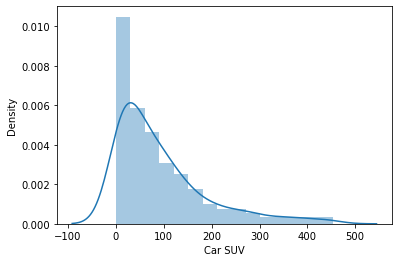

In [184]:
target_0 = data_mod.loc[data_mod['Vehicle Type'] == 'Car SUV']
target_1 = data_mod.loc[data_mod['Vehicle Type'] == 'Minivan/Van']
target_2 = data_mod.loc[data_mod['Vehicle Type'] == 'Pickup']
target_3 = data_mod.loc[data_mod['Vehicle Type'] == 'Truck SUV']

sns.distplot(target_0[['Production_in_Thousands']], axlabel="Car SUV")



c:\Users\chris\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Minivan/Van', ylabel='Density'>

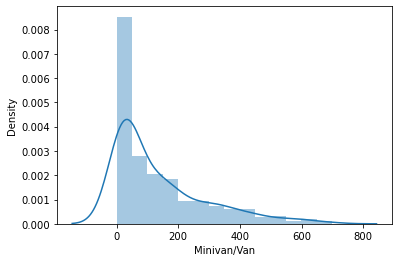

In [185]:
sns.distplot(target_1[['Production_in_Thousands']], axlabel='Minivan/Van')

c:\Users\chris\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Pickup', ylabel='Density'>

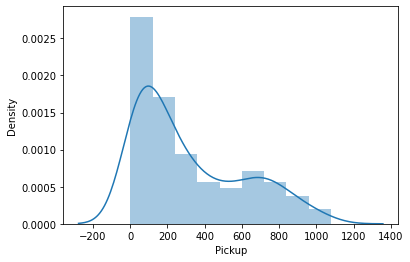

In [186]:
sns.distplot(target_2[['Production_in_Thousands']], axlabel = 'Pickup')


c:\Users\chris\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Truck SUV', ylabel='Density'>

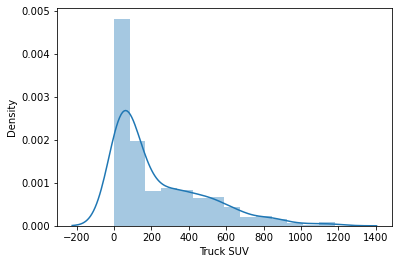

In [187]:
sns.distplot(target_3[['Production_in_Thousands']], axlabel='Truck SUV')

# Perform Transformations on Transmission & Powertrain X-Variables

# 1) Transmission Variable:

In [188]:
#Step 1: Perform initial column calculations to get share of totals for each transmission type.
data_mod['Manual_Count'] = data_mod['Production_in_Thousands']*data_mod['Transmission - Manual']

In [189]:
data_mod['Automatic_Count'] = data_mod['Production_in_Thousands']*data_mod['Transmission - Automatic']

In [190]:
data_mod['CVT_Hybrid_Count'] = data_mod['Production_in_Thousands']*data_mod['Transmission - CVT (Hybrid)']

In [191]:
data_mod['CVT_Non-Hybrid_Count'] = data_mod['Production_in_Thousands']*data_mod['Transmission - CVT (Non-Hybrid)']

In [192]:
data_mod['Lockup_Count'] = data_mod['Production_in_Thousands']*data_mod['Transmission - Lockup']

In [193]:
data_mod['Other_Trans_Count'] = data_mod['Production_in_Thousands']*data_mod['Transmission - Other']

In [194]:
#Step 2: Define newly calculated total production. 
data_mod['Prod_total_trans'] = data_mod['Automatic_Count'] + data_mod['CVT_Hybrid_Count'] + data_mod['CVT_Non-Hybrid_Count'] + data_mod['Lockup_Count'] + data_mod['Other_Trans_Count'] + data_mod['Manual_Count']

In [195]:
#Step 3: Return the mean of "Production in Thousands" column for exploratory analysis.
(data_mod['Production_in_Thousands']-data_mod['Prod_total_trans']).mean()

-158.3080269333337

In [196]:
#Step 4: Create a dictionary of the totals of each model year for each transmission type.
totals_manual = data_mod.groupby('Model Year')['Manual_Count'].sum().to_dict()

In [197]:
#Step 5: Convert the dictionary into a column.
data_mod["total_manual"] = data_mod["Model Year"].map(totals_manual)

In [198]:
#Step 6: Create a column of the share of total manuals each year.
data_mod["manual_total_share"]= data_mod['Manual_Count']/data_mod['total_manual']

In [199]:
#Repeat Steps 1-6 for remaining variables:
totals_cvt_hybrid = data_mod.groupby('Model Year')['CVT_Hybrid_Count'].sum().to_dict()

In [200]:
data_mod["total_cvt_hybrid"] = data_mod["Model Year"].map(totals_cvt_hybrid)

In [201]:
data_mod["cvt_hybrid_total_share"]= data_mod['CVT_Hybrid_Count']/data_mod['total_cvt_hybrid']

In [202]:
totals_cvt_nonhybrid = data_mod.groupby('Model Year')['CVT_Non-Hybrid_Count'].sum().to_dict()

In [203]:
data_mod["total_cvt_nonhybrid"] = data_mod["Model Year"].map(totals_cvt_nonhybrid)

In [204]:
data_mod["cvt_nonhybrid_total_share"]= data_mod['CVT_Non-Hybrid_Count']/data_mod['total_cvt_nonhybrid']

In [205]:
totals_lockup = data_mod.groupby('Model Year')['Lockup_Count'].sum().to_dict()

In [206]:
data_mod["total_lockup"] = data_mod["Model Year"].map(totals_lockup)

In [207]:
data_mod["lockup_total_share"]= data_mod['Lockup_Count']/data_mod['total_lockup']

In [208]:
totals_other = data_mod.groupby('Model Year')['Other_Trans_Count'].sum().to_dict()

In [209]:
data_mod["total_other"] = data_mod["Model Year"].map(totals_other)

In [210]:
data_mod["other_total_share"]= data_mod['Other_Trans_Count']/data_mod['total_other']

In [211]:
#View columns to delete original variables and only keep the newly transformed ones above.
data_mod.columns

Index(['Manufacturer', 'Model Year', 'Regulatory Class', 'Vehicle Type',
       'Production_in_Thousands', 'Real_World_MPG', 'Real-World MPG_City',
       'Real_World_MPG_Hwy', 'Real-World CO2 (g/mi)',
       'Real-World CO2_City (g/mi)', 'Real-World CO2_Hwy (g/mi)',
       'Vehicle_Weight', 'Vehicle_Footprint', 'Engine Displacement',
       'Horsepower', 'Acceleration (0-60 time in seconds)',
       'HP/Engine Displacement', 'HP/Weight', 'Ton-MPG (Real-World)',
       'Drivetrain - Front', 'Drivetrain - 4WD', 'Drivetrain - Rear',
       'Transmission - Manual', 'Transmission - Automatic',
       'Transmission - Lockup', 'Transmission - CVT (Hybrid)',
       'Transmission - Other', 'Fuel Delivery - Carbureted',
       'Fuel Delivery - Gasoline Direct Injection (GDI)',
       'Fuel Delivery - Port Fuel Injection',
       'Fuel Delivery - Throttle Body Injection', 'Fuel Delivery - Other',
       'Powertrain - Diesel', 'Powertrain - Electric Vehicle (EV)',
       'Powertrain - Plug-in Hyb

In [212]:
#Delete original variables, to keep only the transformations for next regression model building.
del data_mod['Transmission - Manual']

In [213]:
data_mod.drop(columns=['Transmission - Automatic','Transmission - Lockup'],inplace = True)

In [214]:
data_mod.drop(columns=['Transmission - CVT (Non-Hybrid)','Transmission - Other', 'Manual_Count', 'Automatic_Count', 'CVT_Hybrid_Count',
       'CVT_Non-Hybrid_Count', 'Lockup_Count', 'Other_Trans_Count',
       'Prod_total_trans', 'total_manual', ],inplace = True)

In [215]:
data_mod.drop(columns=['total_cvt_hybrid','total_cvt_nonhybrid','total_lockup','total_other'],inplace = True)

# 2) Powertrain Variables:

In [216]:
#Repeat transformation process for Powertrain variables.
data_mod['Powertrain_Count1'] = data_mod['Production_in_Thousands']*data_mod['Powertrain - Electric Vehicle (EV)']
data_mod['Powertrain_Count2'] = data_mod['Production_in_Thousands']*data_mod[ 'Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)']
data_mod['Powertrain_Count3'] = data_mod['Production_in_Thousands']*data_mod['Powertrain - Fuel Cell Vehicle (FCV)']
data_mod['Powertrain_Count5'] = data_mod['Production_in_Thousands']*data_mod['Powertrain - Gasoline Hybrid']
data_mod['Powertrain_Count6'] = data_mod['Production_in_Thousands']*data_mod['Powertrain - Gasoline']

In [217]:
#Create Powertrain dictionaries.
totals_powertrain1 = data_mod.groupby('Model Year')['Powertrain - Electric Vehicle (EV)'].sum().to_dict()
totals_powertrain2 = data_mod.groupby('Model Year')['Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)'].sum().to_dict()
totals_powertrain3 = data_mod.groupby('Model Year')['Powertrain - Fuel Cell Vehicle (FCV)'].sum().to_dict()
totals_powertrain5 = data_mod.groupby('Model Year')['Powertrain - Gasoline Hybrid'].sum().to_dict()
totals_powertrain6 = data_mod.groupby('Model Year')['Powertrain - Gasoline'].sum().to_dict()

#Convert dictionaries to Columns.
data_mod["total_p1"] = data_mod["Model Year"].map(totals_powertrain1)
data_mod["total_p2"] = data_mod["Model Year"].map(totals_powertrain2)
data_mod["total_p3"] = data_mod["Model Year"].map(totals_powertrain3)
data_mod["total_p5"] = data_mod["Model Year"].map(totals_powertrain5)
data_mod["total_p6"] = data_mod["Model Year"].map(totals_powertrain6)

#Create columns of the share of total powertrain by year.
data_mod["Powertrain_Electric"] = data_mod['Powertrain_Count1']/data_mod['total_p1']
data_mod["Powertrain_Plugin_Hybrid"] = data_mod['Powertrain_Count2']/data_mod['total_p2']
data_mod["Powertrain_Fuel_Cell"] = data_mod['Powertrain_Count3']/data_mod['total_p3']
data_mod["Powertrain_Gasoline_Hybrid"] = data_mod['Powertrain_Count5']/data_mod['total_p5']
data_mod["Powertrain_Gasoline"] = data_mod['Powertrain_Count6']/data_mod['total_p6']

In [218]:
#View columns to drop the original Powertrain variables, and only keep the newly transformed ones.
data_mod.columns

Index(['Manufacturer', 'Model Year', 'Regulatory Class', 'Vehicle Type',
       'Production_in_Thousands', 'Real_World_MPG', 'Real-World MPG_City',
       'Real_World_MPG_Hwy', 'Real-World CO2 (g/mi)',
       'Real-World CO2_City (g/mi)', 'Real-World CO2_Hwy (g/mi)',
       'Vehicle_Weight', 'Vehicle_Footprint', 'Engine Displacement',
       'Horsepower', 'Acceleration (0-60 time in seconds)',
       'HP/Engine Displacement', 'HP/Weight', 'Ton-MPG (Real-World)',
       'Drivetrain - Front', 'Drivetrain - 4WD', 'Drivetrain - Rear',
       'Transmission - CVT (Hybrid)', 'Fuel Delivery - Carbureted',
       'Fuel Delivery - Gasoline Direct Injection (GDI)',
       'Fuel Delivery - Port Fuel Injection',
       'Fuel Delivery - Throttle Body Injection', 'Fuel Delivery - Other',
       'Powertrain - Diesel', 'Powertrain - Electric Vehicle (EV)',
       'Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)',
       'Powertrain - Fuel Cell Vehicle (FCV)', 'Powertrain - Gasoline Hybrid',
       

In [219]:
#Drop original Powertrain variables, keeping only the transformations that will be used in the regression.
data_mod.drop(columns=['Powertrain - Diesel', 'Powertrain - Electric Vehicle (EV)',
'Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)',
'Powertrain - Fuel Cell Vehicle (FCV)', 'Powertrain - Gasoline Hybrid',
'Powertrain - Gasoline'
],inplace = True)

In [220]:
data_mod.drop(columns=[ 'Powertrain_Count1', 'Powertrain_Count2', 'Powertrain_Count3',
       'Powertrain_Count5', 'Powertrain_Count6', 'total_p1', 'total_p2',
       'total_p3', 'total_p5', 'total_p6'
],inplace = True)

In [221]:
data_mod.drop(columns=['Transmission - CVT (Hybrid)','Powertrain - Electric Vehicle (EV) '],inplace = True)

In [222]:
#Ensure there are no null values in any of the new columns.
data_mod.isna().sum()

Manufacturer                                       0
Model Year                                         0
Regulatory Class                                   0
Vehicle Type                                       0
Production_in_Thousands                            0
Real_World_MPG                                     0
Real-World MPG_City                                0
Real_World_MPG_Hwy                                 0
Real-World CO2 (g/mi)                              0
Real-World CO2_City (g/mi)                         0
Real-World CO2_Hwy (g/mi)                          0
Vehicle_Weight                                     0
Vehicle_Footprint                                  0
Engine Displacement                                0
Horsepower                                         0
Acceleration (0-60 time in seconds)                0
HP/Engine Displacement                             0
HP/Weight                                          0
Ton-MPG (Real-World)                          

# Correlation Testing Post Data Transformations

<AxesSubplot:>

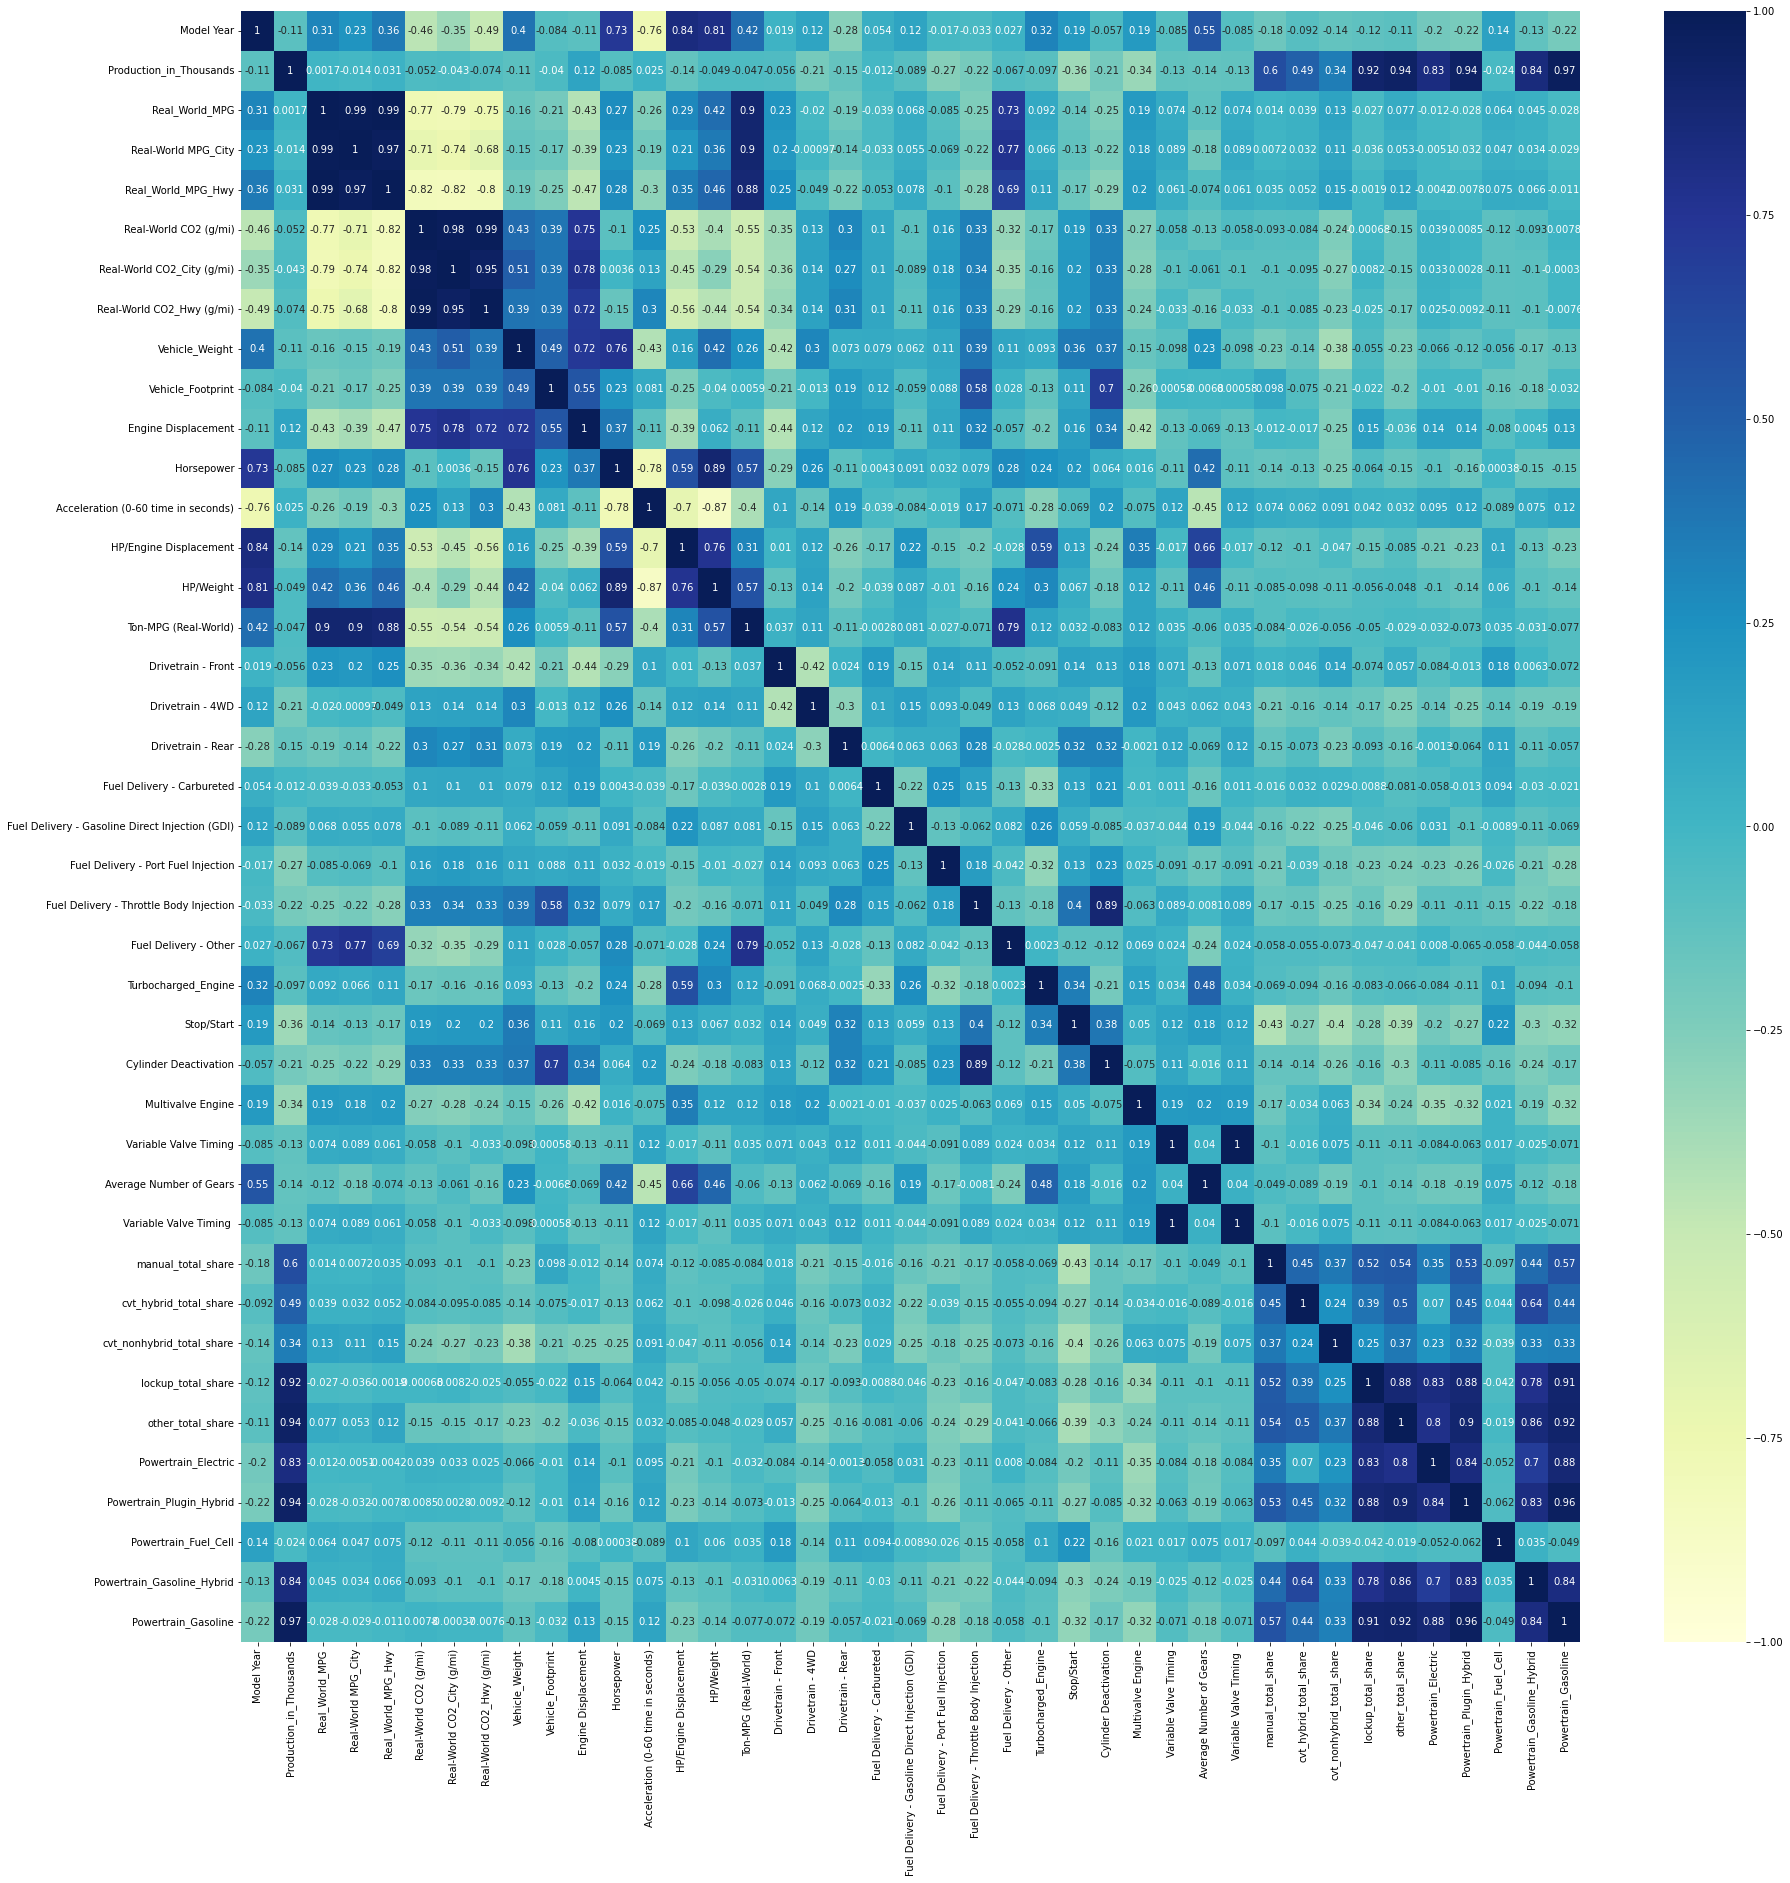

In [223]:
#Visual analysis: difficult to identify from heatmap which x and y variables to use for next regression test, due to large number of variables.

plt.figure(figsize=(30,30))

sns.heatmap(data_mod[data_mod["Production_in_Thousands"]>0.5].corr(),vmin=-1,vmax=1, annot=True, cmap="YlGnBu")

In [224]:
#Identify correlations in array format instead, with "Production in Thousands" being the target variable.
#Following data transformations, strong correlation results have been achieved for "manual_total_share" to Powertrain_Gasoline" variables (60%+). 
correlation = data_mod.corr()
correlations = correlation.iloc[1]
correlations.sort_values()

Stop/Start                                        -0.358318
Multivalve Engine                                 -0.343898
Fuel Delivery - Port Fuel Injection               -0.267319
Fuel Delivery - Throttle Body Injection           -0.215587
Drivetrain - 4WD                                  -0.211879
Cylinder Deactivation                             -0.208810
Drivetrain - Rear                                 -0.148025
HP/Engine Displacement                            -0.135859
Average Number of Gears                           -0.133950
Variable Valve Timing                             -0.128838
Variable Valve Timing                             -0.128838
Model Year                                        -0.105623
Vehicle_Weight                                    -0.104450
Turbocharged_Engine                               -0.096663
Fuel Delivery - Gasoline Direct Injection (GDI)   -0.086793
Horsepower                                        -0.081484
Real-World CO2_Hwy (g/mi)               

# Merging External DataFrame to Incorporate Population & Income data for Model Testing

In [225]:
#Import supplemental Income and Population data into new dataframes.
population_data = pd.read_csv("UnitedStates_Population.csv")

income_data = pd.read_csv("Median_Personal_Income.csv")


In [226]:
#Combine the new data on the primary key.
Population_and_Income_Data = population_data.join(income_data.set_index('Model Year'), on='Model Year')

In [227]:
#Join the additional data to the original dataframe.
data_mod = data_mod.join(Population_and_Income_Data.set_index('Model Year'), on='Model Year')

In [228]:
#Ensure that the two new columns have been added. Now the data is ready for final regression modelling!
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1875 entries, 304 to 5049
Data columns (total 46 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Manufacturer                                     1875 non-null   object 
 1   Model Year                                       1875 non-null   int32  
 2   Regulatory Class                                 1875 non-null   object 
 3   Vehicle Type                                     1875 non-null   object 
 4   Production_in_Thousands                          1875 non-null   int32  
 5   Real_World_MPG                                   1875 non-null   float64
 6   Real-World MPG_City                              1875 non-null   float64
 7   Real_World_MPG_Hwy                               1875 non-null   float64
 8   Real-World CO2 (g/mi)                            1875 non-null   float64
 9   Real-World CO2_City (g/mi)  

# Secondary Regression Test

In [229]:
#Regression Modelling - The R2 value is high at 96%, however this is misleading as the data is still skewed to the left and requires normalizing.
model_current = ols('Production_in_Thousands ~ manual_total_share + Powertrain_Electric + Powertrain_Gasoline_Hybrid + lockup_total_share + other_total_share + Powertrain_Plugin_Hybrid + Powertrain_Gasoline',data=data_mod).fit()

In [230]:
print(model_current.summary())

                               OLS Regression Results                              
Dep. Variable:     Production_in_Thousands   R-squared:                       0.965
Model:                                 OLS   Adj. R-squared:                  0.965
Method:                      Least Squares   F-statistic:                     7343.
Date:                     Tue, 02 Aug 2022   Prob (F-statistic):               0.00
Time:                             23:14:43   Log-Likelihood:                -11326.
No. Observations:                     1875   AIC:                         2.267e+04
Df Residuals:                         1867   BIC:                         2.271e+04
Df Model:                                7                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [231]:
#Set x and y variables.
x = data_mod[['Real_World_MPG_Hwy','Turbocharged_Engine']]
y = data_mod['Real_World_MPG']

In [232]:
#Split the data between testing and training.
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)

In [233]:
#Train the model.
train_model = LinearRegression().fit(x_train, y_train)

In [234]:
#Print the coefficients and y-intercept.
print(train_model.coef_)
print(train_model.intercept_)

[ 0.97556236 -0.48191365]
-2.2880580821311653


In [235]:
#Build a prediction.
predict = train_model.predict(x_test)

In [236]:
#Print the RMSE & R2 scores - which confirm that the data is biased and currently skewed.
test_rmse = (np.sqrt(mean_squared_error(y_test, predict)))
test_r2 = r2_score(y_test, predict)
print(test_rmse) #the lower the value, the better the fit
print(test_r2) #the closer to 1, the better the fit

1.0194239760911936
0.9889056921018923


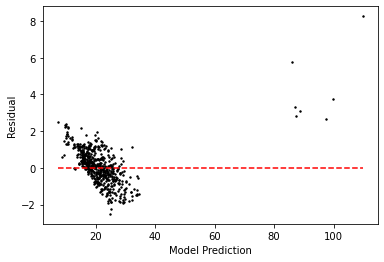

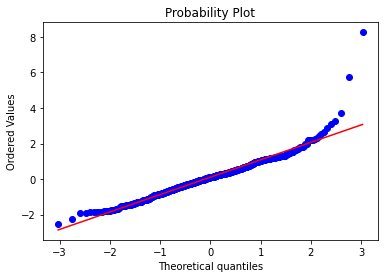

In [237]:
#Understand residual spread.
residuals = y_test - predict

plt.scatter(predict,residuals,s=2,c='black') #s is the size of dots

plt.hlines(0,min(predict),max(predict),color='red',linestyles='dashed') #plot a horizontal red line

plt.xlabel("Model Prediction")
plt.ylabel("Residual")
plt.show()
#QQ
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(residuals,dist='norm',plot=ax)
plt.show()
data_mod = data_mod.rename(columns = {"Production in Thousands":"Production_in_Thousands"})
data_mod = data_mod.rename(columns = {"Production in Thousands":"Production_in_Thousands"})
a = data_mod[['Real_World_MPG_Hwy','Turbocharged_Engine','Real_World_MPG']]
b = data_mod['Production_in_Thousands']
a_train, a_test, b_train, b_test = train_test_split(a,b, test_size=0.3)

c:\Users\chris\anaconda3\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


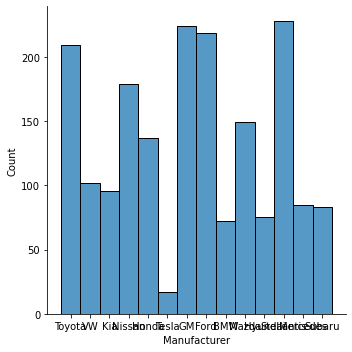

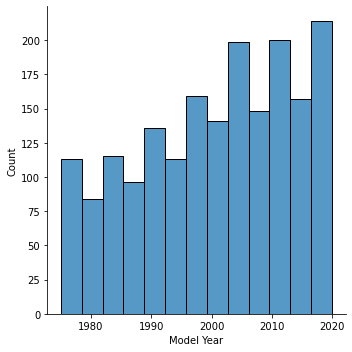

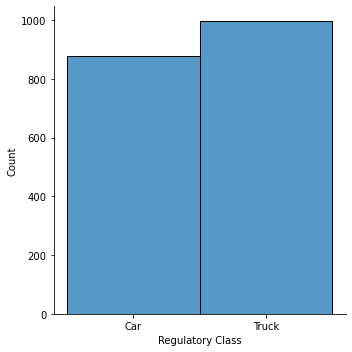

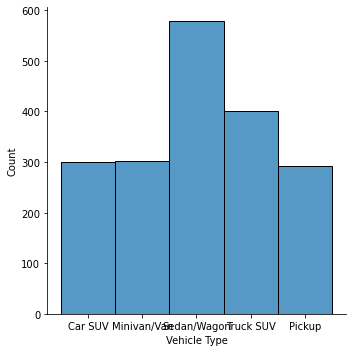

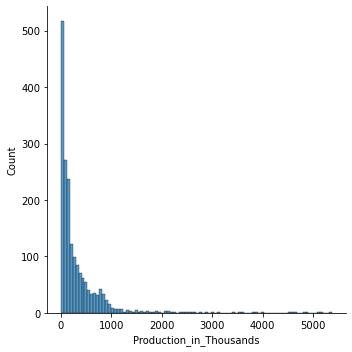

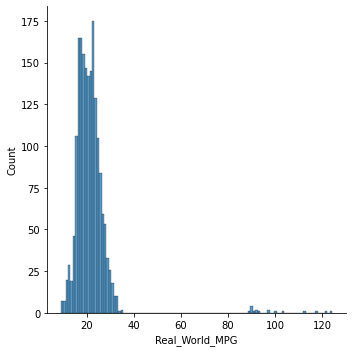

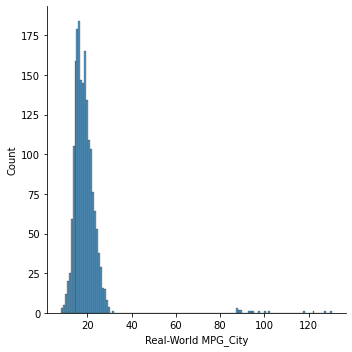

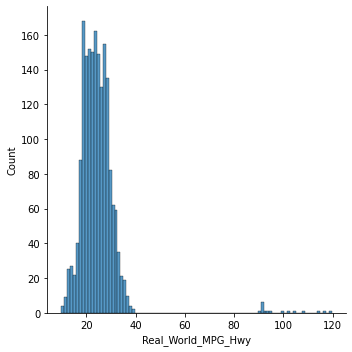

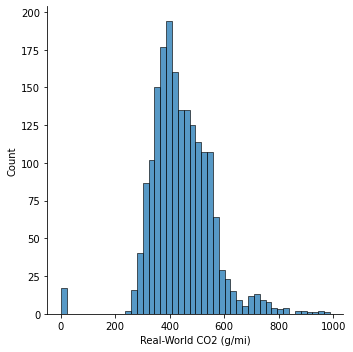

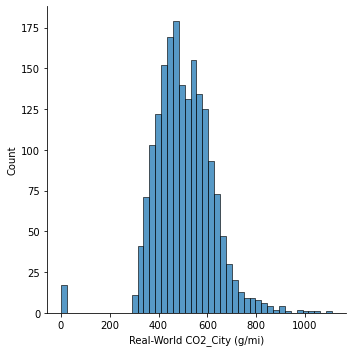

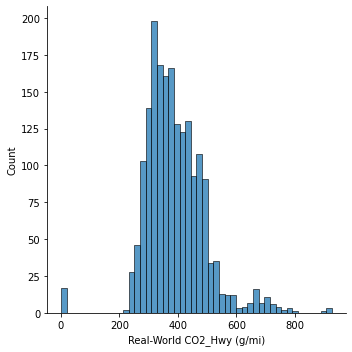

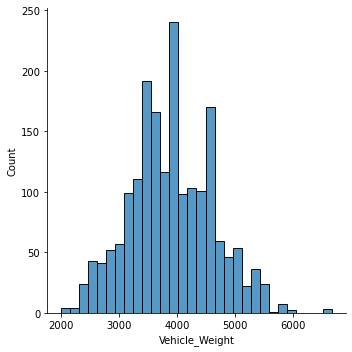

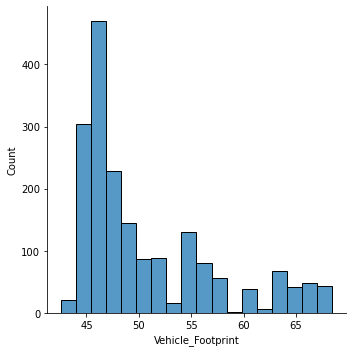

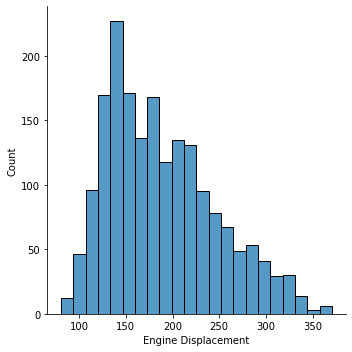

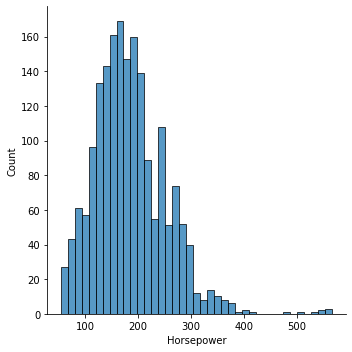

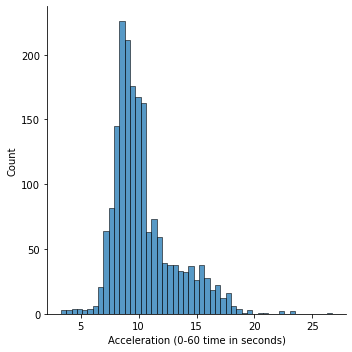

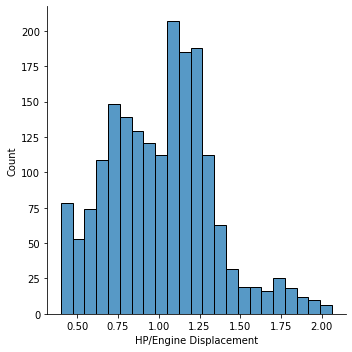

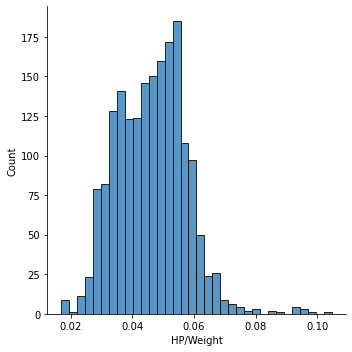

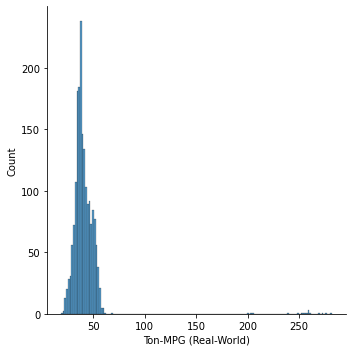

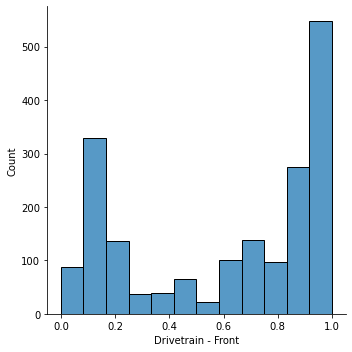

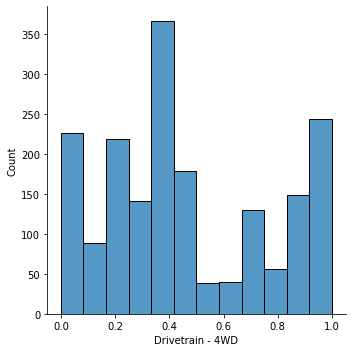

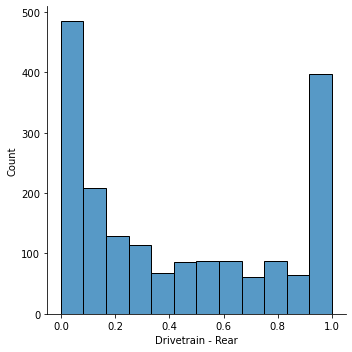

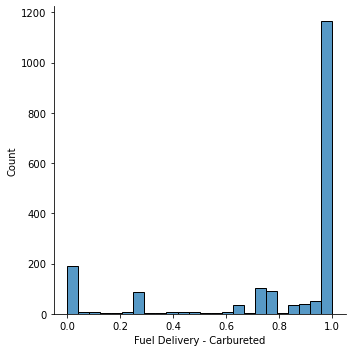

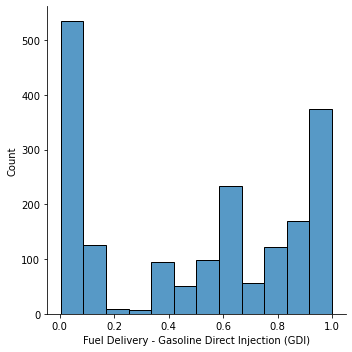

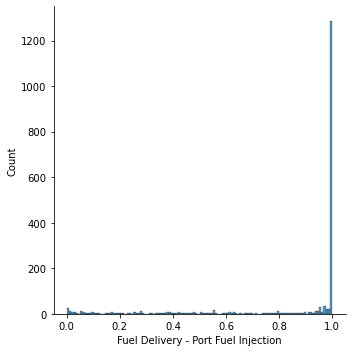

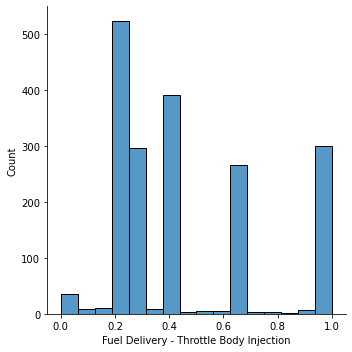

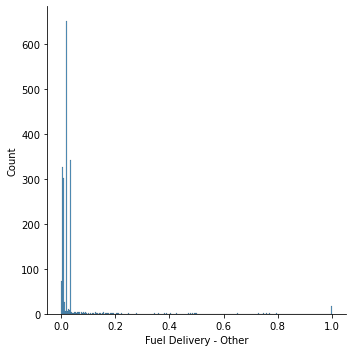

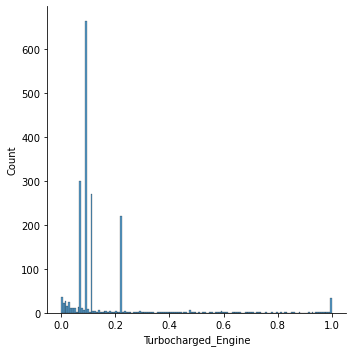

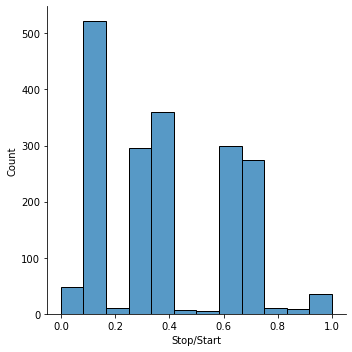

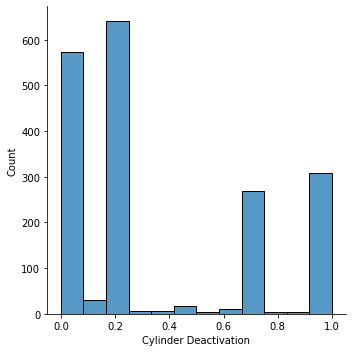

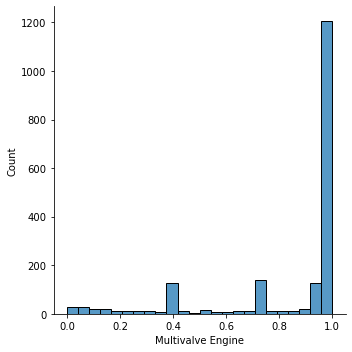

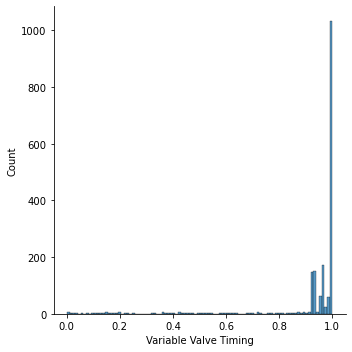

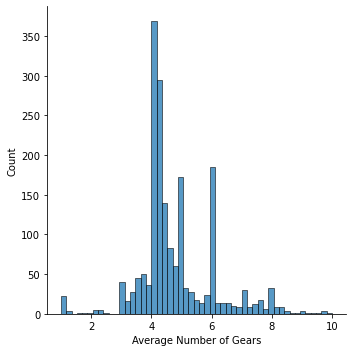

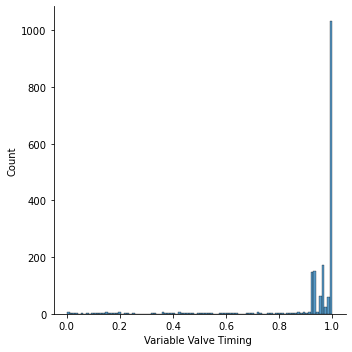

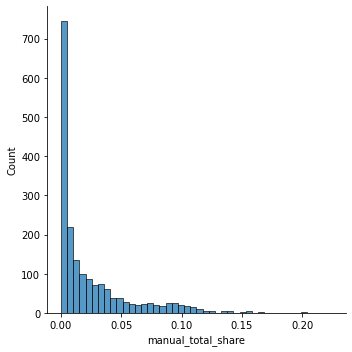

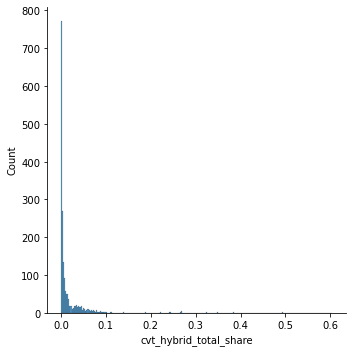

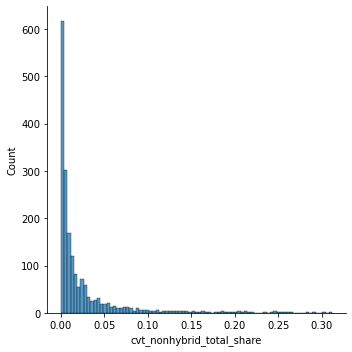

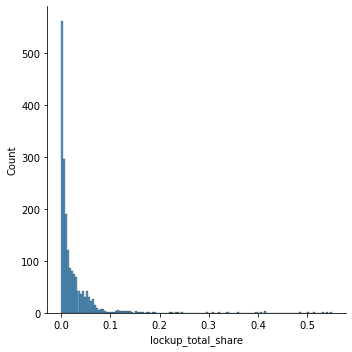

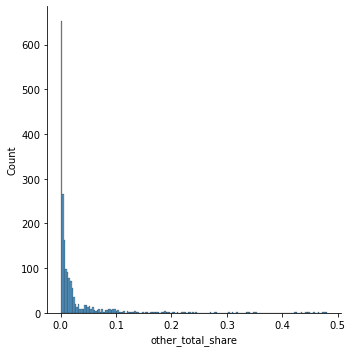

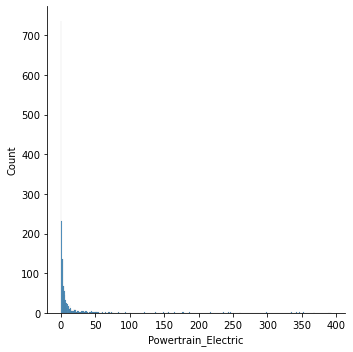

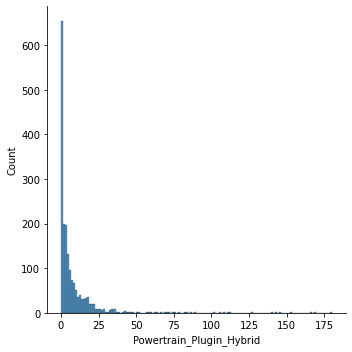

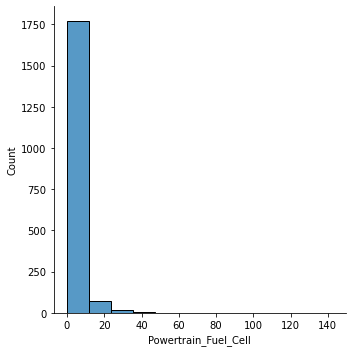

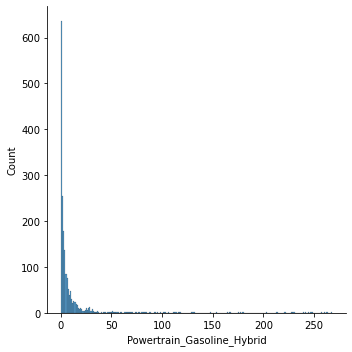

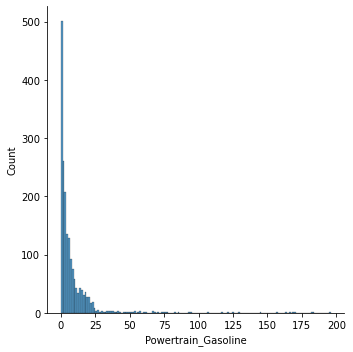

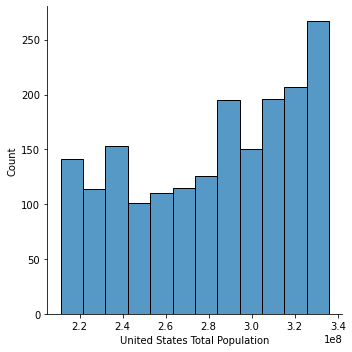

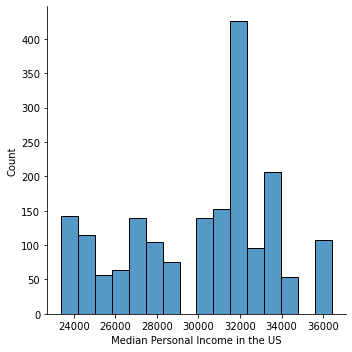

In [238]:
#Review current data distributions prior to normalizing.
for i in data_mod.iloc[1:10]:
    sns.displot(data = data_mod, x=i)

# Perform BoxCox Transformations to Normalize Data

In [239]:
from scipy.stats import boxcox

In [240]:
data_mod = data_mod[data_mod['Production_in_Thousands'] != 0]

In [241]:
production = np.array(data_mod['Production_in_Thousands'])

c:\Users\chris\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

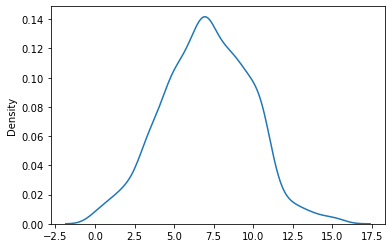

In [242]:
#Perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(production) 

#Plot the distribution of the transformed data values
sns.distplot(transformed_data, hist=False, kde=True)

In [243]:
transformed_production = pd.Series(transformed_data)

In [244]:
transformed_production

0       2.011521
1       2.206873
2       3.230845
3       3.030965
4       1.515538
          ...   
1860    8.981075
1861    9.445253
1862    9.557428
1863    9.958808
1864    9.440837
Length: 1865, dtype: float64

In [245]:
#Define a new variable to call the transformed dataset in later code.
new_data= data_mod.assign(transformed_production = transformed_data)

In [246]:
new_data

,Manufacturer,Model Year,Regulatory Class,Vehicle Type,Production_in_Thousands,Real_World_MPG,Real-World MPG_City,Real_World_MPG_Hwy,Real-World CO2 (g/mi),Real-World CO2_City (g/mi),...,lockup_total_share,other_total_share,Powertrain_Electric,Powertrain_Plugin_Hybrid,Powertrain_Fuel_Cell,Powertrain_Gasoline_Hybrid,Powertrain_Gasoline,United States Total Population,Median Personal Income in the US,transformed_production
304,Toyota,1975,Car,Car SUV,6,10.23844,9.04500,12.20700,868.00369,982.53179,...,0.000714,0.000189,0.136986,0.030132,2.000000,0.221402,0.216975,211274535,24846,2.011521
305,Toyota,1976,Car,Car SUV,7,9.19707,8.00196,11.25082,966.28564,1110.60000,...,0.000661,0.000184,0.159817,0.037508,2.333333,0.258303,0.254499,213270022,24896,2.206873
306,Toyota,1977,Car,Car SUV,15,11.66828,10.72111,13.08073,761.63745,828.92548,...,0.001242,0.000340,0.342466,0.080375,5.000000,0.553506,0.546647,215437405,25084,3.230845
307,Toyota,1978,Car,Car SUV,13,11.07075,9.84348,13.06105,802.74611,902.83121,...,0.001115,0.000291,0.287611,0.067401,4.333333,0.477064,0.458748,217881437,24877,3.030965
308,Toyota,1979,Car,Car SUV,4,11.73531,11.01513,12.75451,757.28745,806.79937,...,0.000641,0.000094,0.095238,0.020847,2.000000,0.152381,0.147978,220463115,24193,1.515538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5045,Subaru,2016,Truck,Truck SUV,402,27.98806,24.49875,31.35727,317.52823,362.75316,...,0.026902,0.008461,1.186091,4.783935,0.000000,2.595941,7.652519,327210198,33545,8.981075
5046,Subaru,2017,Truck,Truck SUV,498,28.47949,24.79520,32.07488,312.04908,358.41619,...,0.032012,0.010362,1.444675,5.414883,0.000000,7.416232,9.399241,329791231,33750,9.445253
5047,Subaru,2018,Truck,Truck SUV,524,28.77334,25.17422,32.25181,308.86225,353.01981,...,0.034153,0.011882,1.097875,5.477948,0.000000,8.000000,10.097701,332140037,34745,9.557428
5048,Subaru,2019,Truck,Truck SUV,627,28.29996,24.69592,31.80101,313.88875,359.65594,...,0.041496,0.015226,1.286342,3.665327,0.000000,6.970539,12.134541,334319671,36426,9.958808


# Create Dummy Variables

In [247]:
new_data.drop(['Production_in_Thousands'], axis=1, inplace=True)

In [248]:
manufacturers = pd.get_dummies(new_data['Manufacturer'])

In [249]:
new_data = pd.concat([new_data, manufacturers], axis=1)

In [250]:
new_data.drop(['Manufacturer'],axis=1, inplace=True)

In [251]:
reg_class = pd.get_dummies(new_data['Regulatory Class'])

In [252]:
new_data = pd.concat([new_data, reg_class], axis=1)

In [253]:
vehicle_type = pd.get_dummies(new_data['Vehicle Type'])

In [254]:
new_data = pd.concat([new_data, vehicle_type], axis=1)

In [255]:
new_data.drop(['Regulatory Class', 'Vehicle Type'],axis=1, inplace=True)

In [256]:
#Analyze revised correlation trends. "Other_total_share" to "Powertrain_Gasoline" variables have a relatively high correlation of 63%+ and are worth including in the next regression.
correlation = new_data.corr()
correlations = correlation.iloc[42]
correlations.sort_values()
print(correlations.sort_values().to_string())

Stop/Start                                        -0.455386
Drivetrain - Rear                                 -0.329769
Multivalve Engine                                 -0.318609
Fuel Delivery - Port Fuel Injection               -0.292894
Car SUV                                           -0.289444
Fuel Delivery - Throttle Body Injection           -0.253564
Drivetrain - 4WD                                  -0.235137
Cylinder Deactivation                             -0.234026
Minivan/Van                                       -0.225249
Mazda                                             -0.222555
Fuel Delivery - Gasoline Direct Injection (GDI)   -0.196082
Truck                                             -0.184033
Variable Valve Timing                             -0.178752
Variable Valve Timing                             -0.178752
Real-World CO2_Hwy (g/mi)                         -0.163539
Kia                                               -0.152860
Real-World CO2 (g/mi)                   

In [257]:
correlations

Model Year               0.031850
Real_World_MPG           0.016974
Real-World MPG_City     -0.017077
Real_World_MPG_Hwy       0.060248
Real-World CO2 (g/mi)   -0.138073
                           ...   
Car SUV                 -0.289444
Minivan/Van             -0.225249
Pickup                   0.042300
Sedan/Wagon              0.427472
Truck SUV               -0.059877
Name: transformed_production, Length: 64, dtype: float64

c:\Users\chris\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='transformed_production', ylabel='Density'>

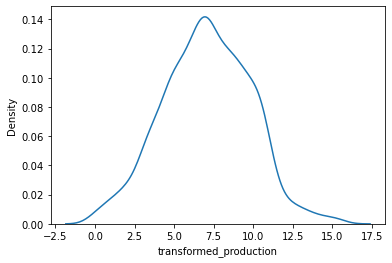

In [258]:
#Plot the transformed_production target variable. Yay! It now appears as a normal distribution!
sns.distplot(new_data['transformed_production'], hist=False, kde=True)

# Testing which Variables to Model

In [259]:
new_data = new_data.rename(columns = {"United States Total Population":"total_pop"})

In [260]:
new_data = new_data.rename(columns = {" Median Personal Income in the US ":"income"})

In [261]:
new_data = new_data.rename(columns = {"HP/Weight":"hp_weight"})

In [262]:
new_data = new_data.rename(columns = {"Stop/Start":"stop_start"})

In [263]:
new_data = new_data.rename(columns = {"Engine Displacement":"engine_displacement"})

In [264]:
new_data.columns

Index(['Model Year', 'Real_World_MPG', 'Real-World MPG_City',
       'Real_World_MPG_Hwy', 'Real-World CO2 (g/mi)',
       'Real-World CO2_City (g/mi)', 'Real-World CO2_Hwy (g/mi)',
       'Vehicle_Weight', 'Vehicle_Footprint', 'engine_displacement',
       'Horsepower', 'Acceleration (0-60 time in seconds)',
       'HP/Engine Displacement', 'hp_weight', 'Ton-MPG (Real-World)',
       'Drivetrain - Front', 'Drivetrain - 4WD', 'Drivetrain - Rear',
       'Fuel Delivery - Carbureted',
       'Fuel Delivery - Gasoline Direct Injection (GDI)',
       'Fuel Delivery - Port Fuel Injection',
       'Fuel Delivery - Throttle Body Injection', 'Fuel Delivery - Other',
       'Turbocharged_Engine', 'stop_start', 'Cylinder Deactivation',
       'Multivalve Engine', 'Variable Valve Timing', 'Average Number of Gears',
       'Variable Valve Timing ', 'manual_total_share',
       'cvt_hybrid_total_share', 'cvt_nonhybrid_total_share',
       'lockup_total_share', 'other_total_share', 'Powertrain_Elect

In [265]:
#Regression Modelling
model_current = ols('transformed_production ~ manual_total_share + Powertrain_Electric + Powertrain_Gasoline + lockup_total_share + Powertrain_Plugin_Hybrid + Powertrain_Gasoline + income + engine_displacement + stop_start',data=new_data).fit()
print(model_current.summary())

                              OLS Regression Results                              
Dep. Variable:     transformed_production   R-squared:                       0.681
Model:                                OLS   Adj. R-squared:                  0.680
Method:                     Least Squares   F-statistic:                     495.1
Date:                    Tue, 02 Aug 2022   Prob (F-statistic):               0.00
Time:                            23:14:59   Log-Likelihood:                -3480.2
No. Observations:                    1865   AIC:                             6978.
Df Residuals:                        1856   BIC:                             7028.
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [266]:
new_data['Powertrain_Electric'].corr(new_data['Powertrain_Plugin_Hybrid'])

0.8383570071424924

In [267]:
new_data.columns

Index(['Model Year', 'Real_World_MPG', 'Real-World MPG_City',
       'Real_World_MPG_Hwy', 'Real-World CO2 (g/mi)',
       'Real-World CO2_City (g/mi)', 'Real-World CO2_Hwy (g/mi)',
       'Vehicle_Weight', 'Vehicle_Footprint', 'engine_displacement',
       'Horsepower', 'Acceleration (0-60 time in seconds)',
       'HP/Engine Displacement', 'hp_weight', 'Ton-MPG (Real-World)',
       'Drivetrain - Front', 'Drivetrain - 4WD', 'Drivetrain - Rear',
       'Fuel Delivery - Carbureted',
       'Fuel Delivery - Gasoline Direct Injection (GDI)',
       'Fuel Delivery - Port Fuel Injection',
       'Fuel Delivery - Throttle Body Injection', 'Fuel Delivery - Other',
       'Turbocharged_Engine', 'stop_start', 'Cylinder Deactivation',
       'Multivalve Engine', 'Variable Valve Timing', 'Average Number of Gears',
       'Variable Valve Timing ', 'manual_total_share',
       'cvt_hybrid_total_share', 'cvt_nonhybrid_total_share',
       'lockup_total_share', 'other_total_share', 'Powertrain_Elect

In [268]:
y = new_data['transformed_production']
x = new_data[["Acceleration (0-60 time in seconds)","Powertrain_Gasoline","manual_total_share","Sedan/Wagon","GM","stop_start", "Mazda","Car SUV","Drivetrain - Rear", "Real_World_MPG"]]

In [269]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30, random_state = 42)

In [270]:
x_train

,Acceleration (0-60 time in seconds),Powertrain_Gasoline,manual_total_share,Sedan/Wagon,GM,stop_start,Mazda,Car SUV,Drivetrain - Rear,Real_World_MPG
974,8.1728,2.340373,0.001823,0,0,0.2695,0,0,0.5280,18.50060
3888,10.6238,0.736226,0.000106,0,0,0.3780,0,0,0.0495,18.97893
5048,9.5261,12.134541,0.005212,0,0,0.2840,0,0,0.0300,28.29996
547,23.1548,0.607764,0.003499,0,0,0.6600,0,0,1.0000,16.23834
4407,15.1003,22.736616,0.082386,0,0,0.2695,0,0,0.7150,16.60958
...,...,...,...,...,...,...,...,...,...,...
3241,9.3161,0.072886,0.000099,0,0,0.7290,0,1,1.0000,13.92779
3892,10.3270,0.277822,0.000047,0,0,0.3780,0,0,0.0495,18.36901
2444,6.8996,6.315139,0.015366,1,0,0.7360,0,0,0.4570,27.10611
4382,9.7311,2.877441,0.011680,0,0,0.6600,0,0,0.2410,18.13697


# Building Final Linear Regression

In [271]:
from sklearn.linear_model import LinearRegression
import scipy, scipy.stats
import sklearn

In [272]:
train_model = sklearn.linear_model.LinearRegression().fit(x,y)

In [273]:
train_model = sklearn.linear_model.LinearRegression().fit(x,y)

In [274]:
train_model.coef_

array([-1.66736679e-01,  5.76962890e-02,  2.75231587e+01,  5.27285204e-01,
        1.06009113e+00, -9.70714007e-01, -9.67077117e-01, -3.45801065e-01,
       -1.25321058e+00, -2.19407796e-02])

In [275]:
train_model.intercept_

8.87033923936541

In [276]:
train_model = sklearn.linear_model.LinearRegression().fit(x_train,y_train)

In [277]:
train_model.coef_

array([-1.70292665e-01,  5.80006440e-02,  2.61622539e+01,  4.36703806e-01,
        1.10007970e+00, -1.22861805e+00, -9.38183664e-01, -4.12299005e-01,
       -1.24787335e+00, -1.57685996e-02])

In [278]:
predict = train_model.predict(x_test)

In [279]:
predict

array([ 9.73635614,  6.29442977,  6.09279233, 10.38664773, 12.23074808,
        6.94062755,  7.43753024, 12.16108402,  4.99877342,  4.08645458,
        6.38656612,  4.78725875,  6.68738857, 20.33327148, 10.89883825,
       17.21652582,  3.74799824,  6.739055  ,  7.20281553,  8.76248414,
        9.71375574,  7.20451966,  7.0383827 ,  6.92672041,  7.06759785,
        4.60640071,  5.31363767,  9.16298477, 11.31448232,  5.28826194,
        7.21771482,  7.21120026,  9.49649202,  7.16030842,  7.73460616,
        5.60131678,  4.76923886,  7.13083981,  7.27225816,  6.86356919,
        4.48656873,  7.29242139,  4.82135052,  4.54273904,  8.78116358,
        5.27479238,  6.83319145,  6.7036981 ,  7.69011869,  6.48038857,
        6.38076582, 12.90826643,  9.83294417,  5.15194114,  4.45920962,
        7.39388721,  5.89812209,  4.7763533 ,  8.09383702,  3.84802235,
        7.08156069,  5.5718769 ,  5.71208888,  5.25696876,  8.64022581,
        5.74946605,  6.23238455,  6.24366496,  9.53023098, 12.53

In [280]:
test_rmse = (np.sqrt(mean_squared_error(y_test,predict)))

In [281]:
test_rmse

1.6169393409479702

In [282]:
r2_score(y_test,predict)

0.6423090248452776

In [283]:
residuals = predict - y_test

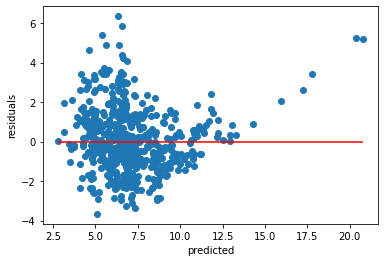

In [284]:
plt.scatter(predict, residuals)
plt.xlabel("predicted")
plt.ylabel("residuals")
plt.hlines(0, min(predict),max(predict), color="red")

((array([-3.02650415e+00, -2.74750744e+00, -2.59084296e+00, -2.47986484e+00,
         -2.39297628e+00, -2.32110044e+00, -2.25952856e+00, -2.20549143e+00,
         -2.15721738e+00, -2.11350190e+00, -2.07348748e+00, -2.03654123e+00,
         -2.00218220e+00, -1.97003603e+00, -1.93980540e+00, -1.91125011e+00,
         -1.88417322e+00, -1.85841114e+00, -1.83382650e+00, -1.81030272e+00,
         -1.78774004e+00, -1.76605239e+00, -1.74516494e+00, -1.72501225e+00,
         -1.70553674e+00, -1.68668744e+00, -1.66841904e+00, -1.65069106e+00,
         -1.63346719e+00, -1.61671470e+00, -1.60040403e+00, -1.58450835e+00,
         -1.56900323e+00, -1.55386640e+00, -1.53907745e+00, -1.52461765e+00,
         -1.51046978e+00, -1.49661795e+00, -1.48304747e+00, -1.46974474e+00,
         -1.45669713e+00, -1.44389289e+00, -1.43132110e+00, -1.41897155e+00,
         -1.40683469e+00, -1.39490160e+00, -1.38316390e+00, -1.37161372e+00,
         -1.36024369e+00, -1.34904683e+00, -1.33801660e+00, -1.32714679e+00,

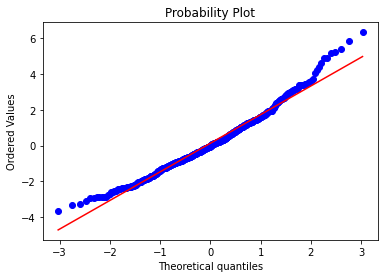

In [285]:
fig = plt.figure()
ax = fig.add_subplot(111)
scipy.stats.probplot(residuals,dist='norm',plot=ax)
#slight positive skew

# Ridge Regression

In [286]:
from sklearn.linear_model import Ridge

In [287]:
rr = Ridge(alpha=0.01)
rr.fit(x_train, y_train) 

Ridge(alpha=0.01)

In [288]:
pred_train_rr= rr.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

1.5877380030882702
0.6768984221542611
1.6174844627396714
0.6420678061326559


# Lasso Regression

In [289]:
from sklearn.linear_model import Lasso

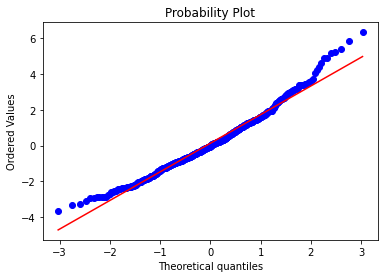

In [290]:
#create Q-Q plot
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(residuals,dist='norm',plot=ax)
plt.show()

In [291]:
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train, y_train) 
pred_train_lasso= model_lasso.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

1.6290315125123376
0.6598735782982827
1.6714905241883646
0.617766836428898


In [303]:
model_lasso.coef_

array([-0.17309836,  0.07208441, 12.80634282,  0.47913261,  0.93267917,
       -1.44000949, -0.90600088, -0.42975697, -1.22606179, -0.01635438])

# Elastic Net Regression

In [292]:
from sklearn.linear_model import ElasticNet

In [293]:
model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(x_train, y_train) 
pred_train_enet= model_enet.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_enet)))
print(r2_score(y_train, pred_train_enet))

pred_test_enet= model_enet.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_enet)))
print(r2_score(y_test, pred_test_enet))

1.7115868518010957
0.6245265074884938
1.7535605183057297
0.5793101396950886


In [304]:
model_enet.coef_

array([-0.17693349,  0.08139752,  2.49409181,  0.57943186,  0.91259527,
       -1.57679494, -0.98093804, -0.51791056, -1.21202936, -0.01729204])

# Random Forest Regression

In [294]:
#Split the data into training and testing set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [295]:
#Build the model
from sklearn.ensemble import RandomForestRegressor
RegModel = RandomForestRegressor(n_estimators=100,criterion='mse')
 
#Printing all the parameters of Random Forest
print(RegModel)
 

RandomForestRegressor(criterion='mse')


In [296]:
#Creating the model on Training data
RF=RegModel.fit(x_train,y_train)
prediction=RF.predict(x_test)

#Measuring Goodness of fit in Training data
from sklearn import metrics
print('R2 Value:',metrics.r2_score(y_test, RF.predict(x_test)))
 
#Measuring accuracy on Testing data
print('Accuracy',100- (np.mean(np.abs((y_test - prediction) / y_test)) * 100))

c:\Users\chris\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


R2 Value: 0.992213451338339
Accuracy -inf


In [297]:
RegModel.feature_importances_

array([1.53401766e-02, 9.79028814e-01, 1.07714929e-03, 3.13829907e-04,
       2.74454574e-04, 6.09180231e-04, 5.17966600e-05, 3.62522415e-05,
       1.33958965e-03, 1.92875726e-03])

In [316]:
feature_names = []
for i in x:
    feature_names.append(i)

In [317]:
feature_names

['Acceleration (0-60 time in seconds)',
 'Powertrain_Gasoline',
 'manual_total_share',
 'Sedan/Wagon',
 'GM',
 'stop_start',
 'Mazda',
 'Car SUV',
 'Drivetrain - Rear',
 'Real_World_MPG']

In [306]:
importances = RegModel.feature_importances_
std = np.std([tree.feature_importances_ for tree in RegModel.estimators_], axis=0)

In [310]:
#Plotting Feature Importances
forest_importances = pd.Series(importances, index=feature_names)


In [320]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in RegModel.estimators_], axis=0)


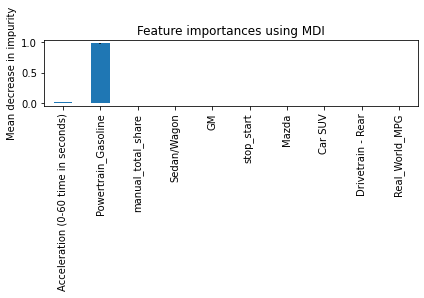

In [321]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [322]:
from sklearn.inspection import permutation_importance

result = permutation_importance(RegModel, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

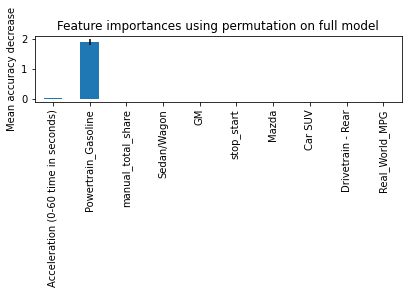

In [323]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Model Output Comparison

In [298]:
#R2 Values:

#Random Forest Regression = 99% 
#Linear Regression = 64%
#Ridge Regression = 64%
#Lasso Regression = 62%
#Elastic Net = 58%



In [324]:
'''
Coefficients: 
Linear Regression = [-1.70292665e-01,  5.80006440e-02,  2.61622539e+01,  4.36703806e-01,
        1.10007970e+00, -1.22861805e+00, -9.38183664e-01, -4.12299005e-01,
       -1.24787335e+00, -1.57685996e-02]
Ridge Regression = [-1.70371303e-01,  5.82516611e-02,  2.58864635e+01,  4.37799930e-01,
        1.09927068e+00, -1.23634417e+00, -9.40085230e-01, -4.12986039e-01,
       -1.24781605e+00, -1.57898014e-02]
Lasso Regression = [-0.17309836,  0.07208441, 12.80634282,  0.47913261,  0.93267917,
       -1.44000949, -0.90600088, -0.42975697, -1.22606179, -0.01635438]
Elastic Net = [-0.17693349,  0.08139752,  2.49409181,  0.57943186,  0.91259527,
       -1.57679494, -0.98093804, -0.51791056, -1.21202936, -0.01729204]
       '''

'\nCoefficients: \nLinear Regression = [-1.70292665e-01,  5.80006440e-02,  2.61622539e+01,  4.36703806e-01,\n        1.10007970e+00, -1.22861805e+00, -9.38183664e-01, -4.12299005e-01,\n       -1.24787335e+00, -1.57685996e-02]\nRidge Regression = [-1.70371303e-01,  5.82516611e-02,  2.58864635e+01,  4.37799930e-01,\n        1.09927068e+00, -1.23634417e+00, -9.40085230e-01, -4.12986039e-01,\n       -1.24781605e+00, -1.57898014e-02]\nLasso Regression = [-0.17309836,  0.07208441, 12.80634282,  0.47913261,  0.93267917,\n       -1.44000949, -0.90600088, -0.42975697, -1.22606179, -0.01635438]\nElastic Net = [-0.17693349,  0.08139752,  2.49409181,  0.57943186,  0.91259527,\n       -1.57679494, -0.98093804, -0.51791056, -1.21202936, -0.01729204]\n       '